# 1.Imports & Reading the Data

In [2]:


# Import Packages




import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
from sklearn.linear_model import LinearRegression
import warnings
from sklearn.exceptions import DataConversionWarning
from sklearn.preprocessing import MinMaxScaler
from math import ceil 
import os
from sklearn.impute import KNNImputer
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm
from minisom import MiniSom
import sompy
from sompy.visualization.mapview import View2D
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, estimate_bandwidth
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

import warnings
import logging
logging.getLogger('matplotlib').setLevel(logging.ERROR)

warnings.filterwarnings(action='ignore', category=UserWarning, module='sklearn')
warnings.filterwarnings("ignore", module="sklearn.cluster._kmeans")

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", module="graphviz")





deprecate positional args: graphviz.backend.piping.pipe(['renderer', 'formatter', 'neato_no_op', 'quiet'])
deprecate positional args: graphviz.backend.rendering.render(['renderer', 'formatter', 'neato_no_op', 'quiet'])
deprecate positional args: graphviz.backend.unflattening.unflatten(['stagger', 'fanout', 'chain', 'encoding'])
deprecate positional args: graphviz.backend.viewing.view(['quiet'])
deprecate positional args: graphviz.quoting.quote(['is_html_string', 'is_valid_id', 'dot_keywords', 'endswith_odd_number_of_backslashes', 'escape_unescaped_quotes'])
deprecate positional args: graphviz.quoting.a_list(['kwargs', 'attributes'])
deprecate positional args: graphviz.quoting.attr_list(['kwargs', 'attributes'])
deprecate positional args: graphviz.dot.Dot.clear(['keep_attrs'])
deprecate positional args: graphviz.dot.Dot.__iter__(['subgraph'])
deprecate positional args: graphviz.dot.Dot.node(['_attributes'])
deprecate positional args: graphviz.dot.Dot.edge(['_attributes'])
deprecate posi

In [3]:
# Read/Import dataset
import pickle
df = pickle.load(open("preprocessed_data_numerical.pkl", "rb"))

In [4]:
metric_features = list(df.columns)
metric_features

['customer_age',
 'Recency',
 'average_product_price',
 'chain_percentage',
 'log_vendor_count',
 'log_order_rate_per_week',
 'log_amount_spent_per_week']

# 2.Segmentation 

## 2.1 Defining our segmentations

In [7]:
demographics_preferences = ['customer_age', 'Recency', 'log_order_rate_per_week', 'log_amount_spent_per_week']


purchase_behavior = ['average_product_price','chain_percentage','log_vendor_count']


In [8]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)))
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)))
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling")
    plt.show()

## 2.2 Segmentation 1 - Demographic preferences 

### Hierarchical + K-means

In [11]:
df_socio1 = df[demographics_preferences]

In [12]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst
    
def get_r2_scores(df, clusterer, min_k=2, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = r2(df, labels)
    return r2_clust


# Set up the clusterers
kmeans = KMeans(
    init='k-means++',
    n_init=20,
    random_state=42
)

hierarchical = AgglomerativeClustering(
    metric='euclidean'
)

In [13]:
# Obtaining the R² scores for each cluster solution on demographic preferences
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_socio1, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df_socio1, hierarchical.set_params(linkage=linkage)
    )

pd.DataFrame(r2_scores)

  File "D:\Outras coisas\Anaconda\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


,kmeans,complete,average,single,ward
2,0.255241,0.218922,0.107604,0.000400,0.191941
3,0.413089,0.322781,0.120857,0.000970,0.336540
4,0.533961,0.331647,0.121557,0.001455,0.447228
5,0.609982,0.355130,0.265977,0.001760,0.547004
6,0.643226,0.356563,0.268199,0.002116,0.590664
7,0.669995,0.367613,0.268296,0.002484,0.619788
8,0.693332,0.464309,0.268374,0.002879,0.642359
9,0.712049,0.468831,0.283719,0.002994,0.659505


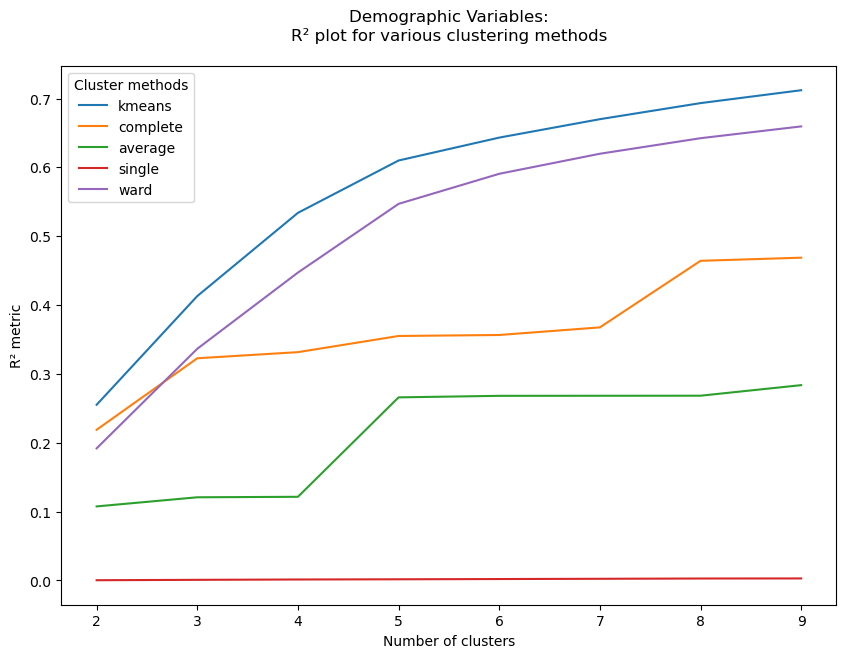

In [14]:
# Visualizing the R² scores for each cluster solution on demographic variables
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("Demographic Variables:\nR² plot for various clustering methods\n")
plt.legend(title="Cluster methods")
plt.xlabel("Number of clusters")
plt.ylabel("R² metric")
plt.show()

Based on the graph above is not clear if we should choose 3 or 4 clusters. The R² isn't very different from 3 to 4 clusters.

In [16]:
kmclust = KMeans(n_clusters=3, init='k-means++', n_init=15, random_state=1)
kmclust.fit(df_socio1)

KMeans(n_clusters=3, n_init=15, random_state=1)

We are going to plot the silhouette_score to decide the final number of clusters.

For n_clusters = 2, the average silhouette_score is : 0.3870579111902149
For n_clusters = 3, the average silhouette_score is : 0.28427584515212506
For n_clusters = 4, the average silhouette_score is : 0.2971329974002685
For n_clusters = 5, the average silhouette_score is : 0.27460741824659896
For n_clusters = 6, the average silhouette_score is : 0.24270282798824624
For n_clusters = 7, the average silhouette_score is : 0.23506672373374074
For n_clusters = 8, the average silhouette_score is : 0.23064017819374322
For n_clusters = 9, the average silhouette_score is : 0.2187311076693287
For n_clusters = 10, the average silhouette_score is : 0.22062964832514068


<Figure size 1300x700 with 0 Axes>

<Figure size 1300x700 with 0 Axes>

<Figure size 1300x700 with 0 Axes>

<Figure size 1300x700 with 0 Axes>

<Figure size 1300x700 with 0 Axes>

<Figure size 1300x700 with 0 Axes>

<Figure size 1300x700 with 0 Axes>

<Figure size 1300x700 with 0 Axes>

<Figure size 1300x700 with 0 Axes>

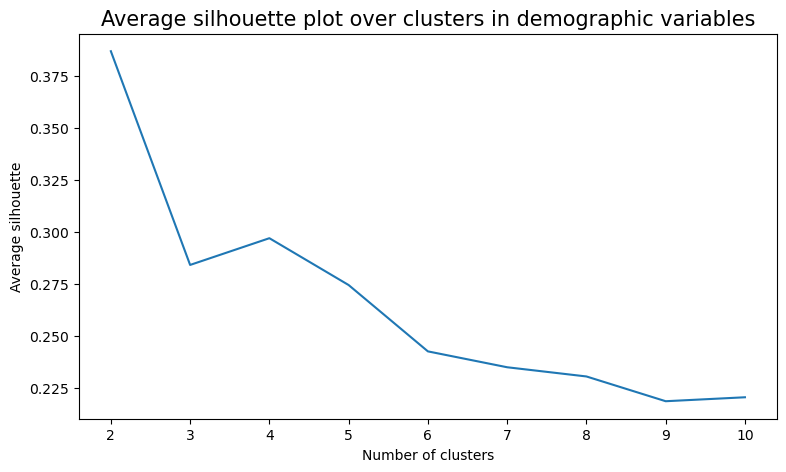

In [18]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

range_clusters = range(1, 11)

# Storing average silhouette metric
avg_silhouette = []
for nclus in range_clusters:
    # Skip nclus == 1
    if nclus == 1:
        continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(df_socio1)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(df_socio1, cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

# The average silhouette plot
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(range_clusters[1:], ## Plot X-axis; Why range_clusters[1:] ? Remember we skipped k=1 in the cell above
         avg_silhouette)     ## Plot Y-axis

plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters in demographic variables", size=15)
plt.show()

It is not very common to see the silhouette_score decreasing as we add more clusters. However, the dataset might have a strong natural separation into 2 groups. Adding more clusters forces the algorithm to split well-formed groups, leading to lower silhouette scores.

Based on that we are going to choose 3 clusters. The difference in silhoete score between 3 and 4 clusters isn't very big. 

In [21]:
df_socio1

,customer_age,Recency,log_order_rate_per_week,log_amount_spent_per_week
0,-1.463397,2.699634,5.373406,3.823580
1,1.490629,2.699634,5.373406,2.894886
2,-0.619389,2.656542,3.731085,3.574793
3,-1.041393,2.656542,3.731085,4.288361
4,1.771965,2.656542,3.731085,3.276592
...,...,...,...,...
31706,0.365286,2.742726,0.941213,0.080469
31707,-0.619389,2.742726,-0.198511,0.080469
31708,-0.478722,2.742726,-0.198511,0.080469
31709,0.927957,2.742726,0.109212,0.080469


In [22]:
# Re-running the Hierarchical clustering based on the correct number of clusters
kmclust = KMeans(n_clusters=3, init='k-means++', n_init=15, random_state=1)
kmclust_labels = kmclust.fit_predict(df_socio1)
df_socio1['kmlust_labels'] = kmclust_labels

df_socio1

,customer_age,Recency,log_order_rate_per_week,log_amount_spent_per_week,kmlust_labels
0,-1.463397,2.699634,5.373406,3.823580,0
1,1.490629,2.699634,5.373406,2.894886,0
2,-0.619389,2.656542,3.731085,3.574793,0
3,-1.041393,2.656542,3.731085,4.288361,0
4,1.771965,2.656542,3.731085,3.276592,0
...,...,...,...,...,...
31706,0.365286,2.742726,0.941213,0.080469,1
31707,-0.619389,2.742726,-0.198511,0.080469,1
31708,-0.478722,2.742726,-0.198511,0.080469,1
31709,0.927957,2.742726,0.109212,0.080469,1


In [23]:
df_socio1['kmlust_labels'].value_counts()

kmlust_labels
2    20016
1     8049
0     3646
Name: count, dtype: int64

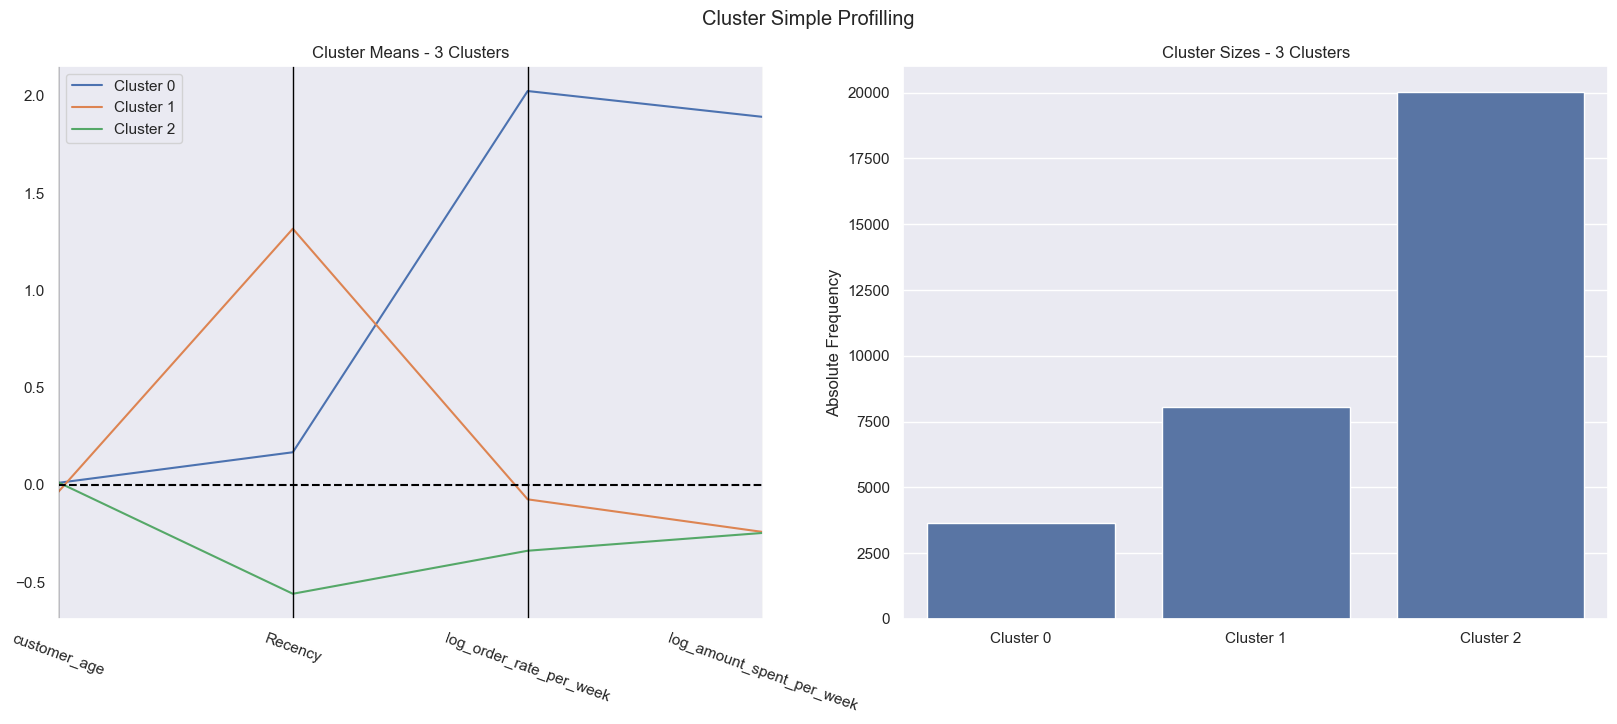

In [24]:
cluster_profiles(df_socio1, ['kmlust_labels'], (20,7))

In [25]:
df_socio1.groupby('kmlust_labels')[demographics_preferences].mean()

,customer_age,Recency,log_order_rate_per_week,log_amount_spent_per_week
kmlust_labels,,,,
0,0.010067,0.167507,2.024912,1.892149
1,-0.038245,1.316899,-0.074540,-0.242103
2,0.013546,-0.560075,-0.338872,-0.247307


### SOM + K-means

In [31]:
df_somk_1 = df[demographics_preferences]

#### SOM Training

In [33]:
np.random.seed(80)

sm = sompy.SOMFactory().build(
    df_somk_1.values, 
    mapsize=[10, 10], 
    initialization='random', 
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=demographics_preferences
)
sm.train(n_job=1, verbose='info', train_rough_len=120, train_finetune_len=120)

 Training...
 random_initialization took: 0.001000 seconds
 Rough training...
 radius_ini: 4.000000 , radius_final: 1.000000, trainlen: 120

 epoch: 1 ---> elapsed time:  0.278000, quantization error: 1.270565

 epoch: 2 ---> elapsed time:  0.168000, quantization error: 1.713694

 epoch: 3 ---> elapsed time:  0.180000, quantization error: 1.651622

 epoch: 4 ---> elapsed time:  0.181000, quantization error: 1.633956

 epoch: 5 ---> elapsed time:  0.166000, quantization error: 1.626711

 epoch: 6 ---> elapsed time:  0.152000, quantization error: 1.621294

 epoch: 7 ---> elapsed time:  0.158000, quantization error: 1.615702

 epoch: 8 ---> elapsed time:  0.136000, quantization error: 1.610996

 epoch: 9 ---> elapsed time:  0.143000, quantization error: 1.607402

 epoch: 10 ---> elapsed time:  0.122000, quantization error: 1.604763

 epoch: 11 ---> elapsed time:  0.163000, quantization error: 1.602460

 epoch: 12 ---> elapsed time:  0.101000, quantization error: 1.600236

 epoch: 13 ---> 

The final quantization error is 0.798841, indicating the average distance between the data points and their corresponding best-matching unit (BMU) after training. Lower values generally indicate better mapping of input data onto the SOM.

#### Choosing the best number of clusters

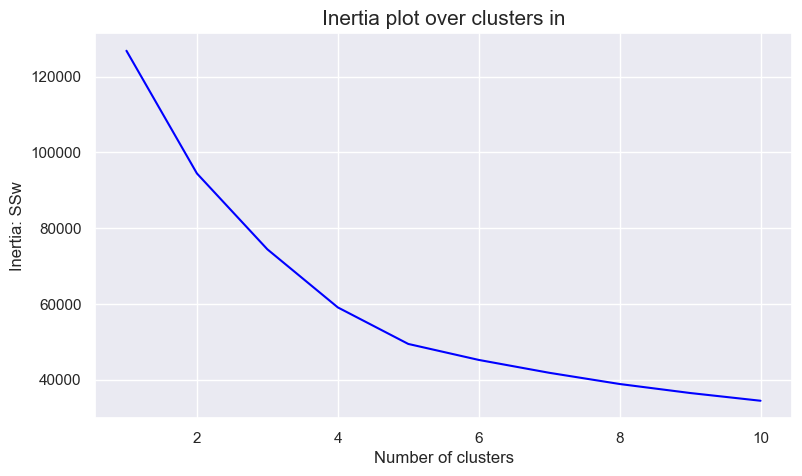

In [36]:
inertia = []
for n_clus in range(1,11): 
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=20, random_state=80)
    kmclust.fit(df_somk_1)
    inertia.append(kmclust.inertia_)

plt.figure(figsize=(9,5))
plt.plot(range(1,11),inertia,color = 'blue')
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters in", size=15)
plt.show()

Beyond 4 clusters, the decrease in inertia slows down, which suggests diminishing returns for adding more clusters.

The "elbow point" appears to be at 4 clusters, where the rate of improvement in inertia reduction becomes less pronounced.

#### U-matrix

#### HitMapView

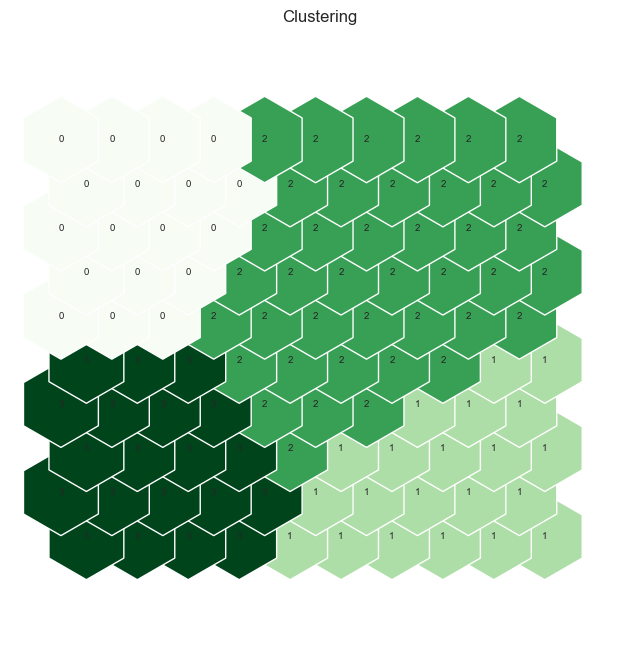

In [40]:
kmeans = KMeans(n_clusters=4,init='k-means++', n_init=20, random_state=42)
nodeclus_labels = kmeans.fit_predict(sm.codebook.matrix)
sm.cluster_labels = nodeclus_labels  # setting the cluster labels of sompy

hits = HitMapView(8,8,"Clustering", text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap=cm.Greens)

plt.show()

Each hexagon represents a neuron in the SOM grid, and the assigned cluster labels (0, 1, 2, 3) are shown inside the respective cells.

#### Final clustering

In [43]:
nodes = sm.codebook.matrix

df_somk = pd.DataFrame(nodes, columns=demographics_preferences)
df_somk['som_kmeans_labels'] = nodeclus_labels
df_somk

,customer_age,Recency,log_order_rate_per_week,log_amount_spent_per_week,som_kmeans_labels
0,-0.557778,-0.684832,-0.779445,-1.118001,2
1,-0.641829,-0.708968,-0.662147,-0.874090,2
2,-0.603471,-0.747189,-0.630746,-0.610614,2
3,-0.334423,-0.736155,-0.590426,-0.518271,2
4,-0.014610,-0.703323,-0.552902,-0.497248,2
...,...,...,...,...,...
95,-0.434139,0.580878,0.304621,0.581164,1
96,-0.412383,0.386510,0.609402,0.875980,3
97,-0.325804,0.420307,1.024535,1.216646,3
98,-0.205274,0.596204,1.547494,1.554194,3


In [44]:
df_somk['som_kmeans_labels'].value_counts()

som_kmeans_labels
2    41
1    21
3    20
0    18
Name: count, dtype: int64

In [45]:
bmus_map = sm.find_bmu(df_somk_1.values)[0]  #get bmus for each observation in df

df_bmus = pd.DataFrame(
    np.concatenate((df_somk_1, np.expand_dims(bmus_map,1)), axis=1),
    index=df_somk_1.index, columns=np.append(df_somk_1.columns,"BMU")
)
df_bmus

,customer_age,Recency,log_order_rate_per_week,log_amount_spent_per_week,BMU
0,-1.463397,2.699634,5.373406,3.823580,89.0
1,1.490629,2.699634,5.373406,2.894886,89.0
2,-0.619389,2.656542,3.731085,3.574793,89.0
3,-1.041393,2.656542,3.731085,4.288361,89.0
4,1.771965,2.656542,3.731085,3.276592,89.0
...,...,...,...,...,...
31706,0.365286,2.742726,0.941213,0.080469,90.0
31707,-0.619389,2.742726,-0.198511,0.080469,91.0
31708,-0.478722,2.742726,-0.198511,0.080469,91.0
31709,0.927957,2.742726,0.109212,0.080469,90.0


In [46]:
df_somk_1 = df_bmus.merge(df_somk['som_kmeans_labels'], 'left', left_on="BMU", right_index=True)

df_somk_1.drop('BMU', axis=1, inplace=True)

df_somk_1.groupby('som_kmeans_labels')[demographics_preferences].mean()

,customer_age,Recency,log_order_rate_per_week,log_amount_spent_per_week
som_kmeans_labels,,,,
0,1.324735,-0.404576,-0.235158,-0.119955
1,-0.197442,1.320509,-0.112103,-0.280120
2,-0.517042,-0.567843,-0.475202,-0.430389
3,-0.238678,-0.035934,1.533017,1.518701


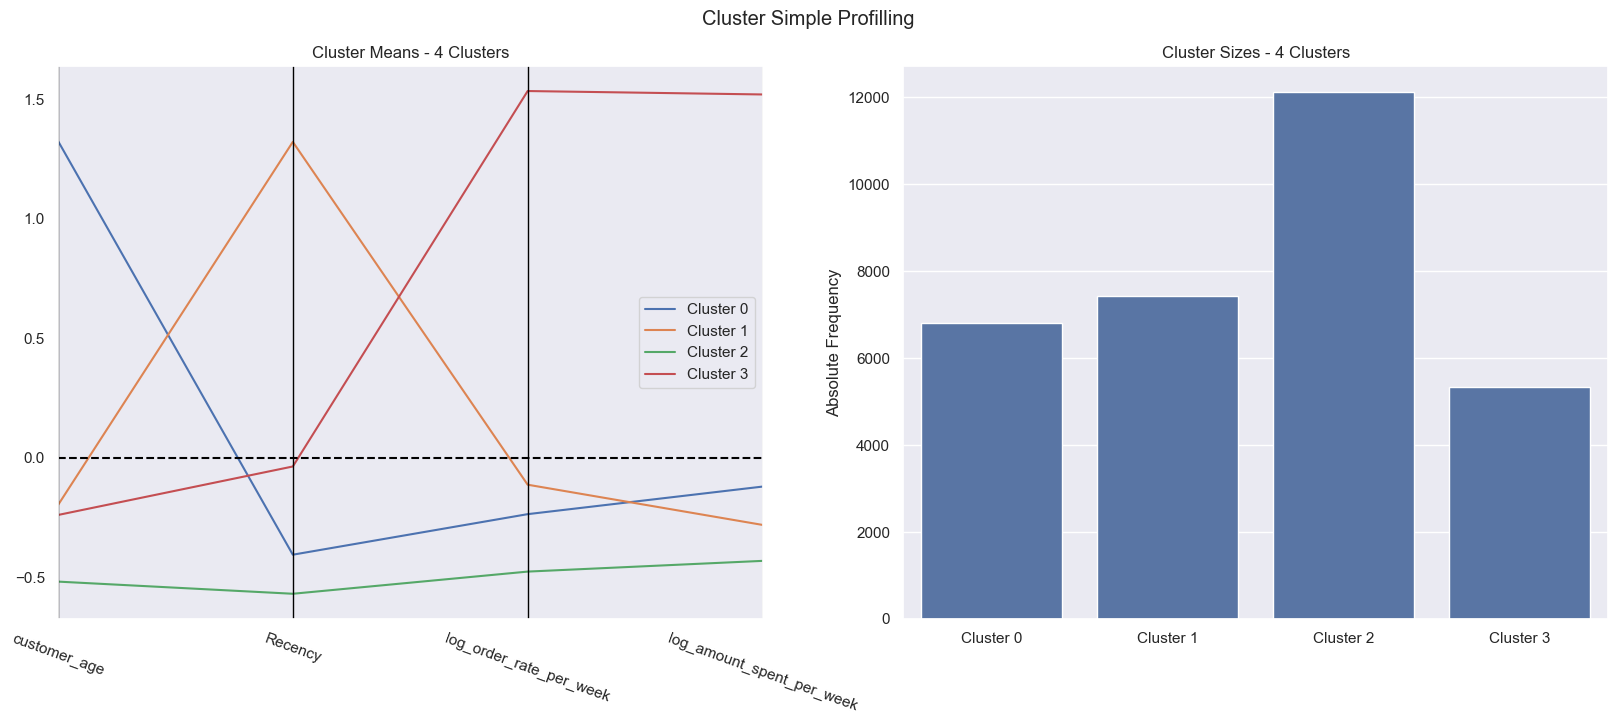

In [47]:
cluster_profiles(df_somk_1, ['som_kmeans_labels'], (20,7))

### SOM + Hierarquical

In [49]:
df_socio3 = df[demographics_preferences]

#### SOM Training

In [51]:
np.random.seed(80)

sm = sompy.SOMFactory().build(
    df_socio3.values, 
    mapsize=[10, 10], 
    initialization='random', 
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=demographics_preferences
)
sm.train(n_job=1, verbose='info', train_rough_len=120, train_finetune_len=120)

 Training...
 random_initialization took: 0.001000 seconds
 Rough training...
 radius_ini: 4.000000 , radius_final: 1.000000, trainlen: 120

 epoch: 1 ---> elapsed time:  0.208000, quantization error: 1.270565

 epoch: 2 ---> elapsed time:  0.182000, quantization error: 1.713694

 epoch: 3 ---> elapsed time:  0.154000, quantization error: 1.651622

 epoch: 4 ---> elapsed time:  0.158000, quantization error: 1.633956

 epoch: 5 ---> elapsed time:  0.126000, quantization error: 1.626711

 epoch: 6 ---> elapsed time:  0.114000, quantization error: 1.621294

 epoch: 7 ---> elapsed time:  0.136000, quantization error: 1.615702

 epoch: 8 ---> elapsed time:  0.185000, quantization error: 1.610996

 epoch: 9 ---> elapsed time:  0.118000, quantization error: 1.607402

 epoch: 10 ---> elapsed time:  0.122000, quantization error: 1.604763

 epoch: 11 ---> elapsed time:  0.150000, quantization error: 1.602460

 epoch: 12 ---> elapsed time:  0.209000, quantization error: 1.600236

 epoch: 13 ---> 

#### Choosing the best number of clusters with Hierarchical

In [53]:
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, metric=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(df_socio3)

array([22319, 29743, 28325, ...,     3,     1,     0], dtype=int64)

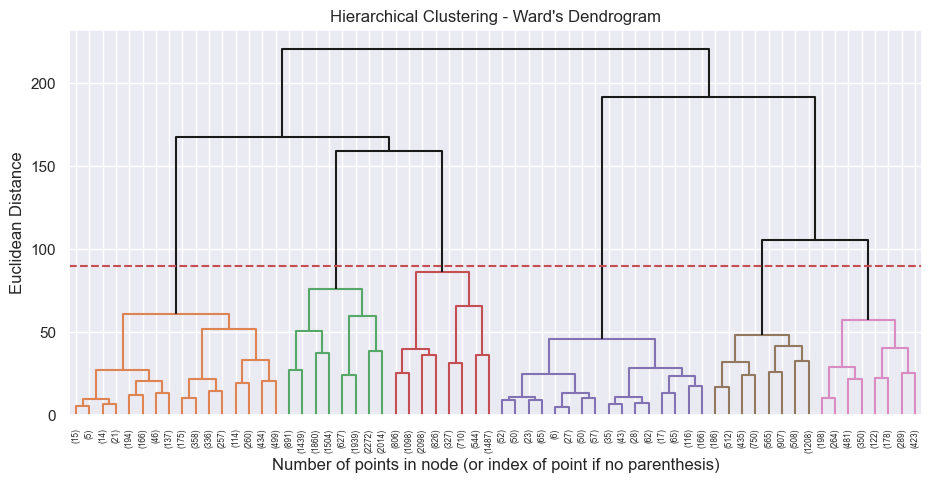

In [54]:
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 90
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram')
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance')
plt.show()

The threshold (red line) intersects just below a noticeable "gap" in the dendrogram.
Above this threshold, the vertical distances between clusters are much larger, meaning clusters are more distinct.


Based on this analysis, 6 clusters is the right choice.

#### HitMapView

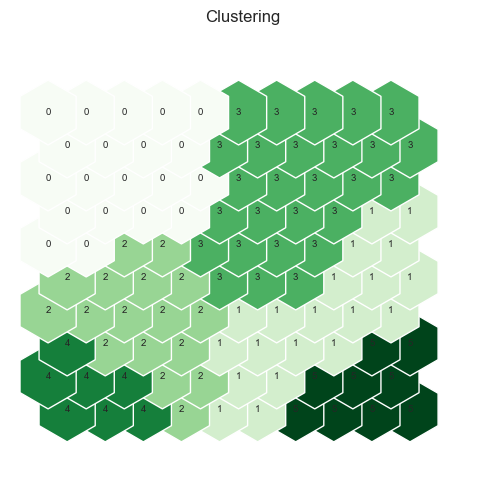

In [58]:
hierclust = AgglomerativeClustering(n_clusters=6, linkage='ward')
node_hier_label= hierclust.fit_predict(sm.codebook.matrix)
sm.cluster_labels = node_hier_label  # setting the cluster labels of sompy

hits  = HitMapView(6,6,"Clustering",text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap=cm.Greens)

plt.show()

#### Final clustering

In [60]:
nodes = sm.codebook.matrix

hnodes = pd.DataFrame(nodes, columns=demographics_preferences)
hnodes['som_hierar_labels'] = node_hier_label
hnodes

,customer_age,Recency,log_order_rate_per_week,log_amount_spent_per_week,som_hierar_labels
0,-0.557778,-0.684832,-0.779445,-1.118001,3
1,-0.641829,-0.708968,-0.662147,-0.874090,3
2,-0.603471,-0.747189,-0.630746,-0.610614,3
3,-0.334423,-0.736155,-0.590426,-0.518271,3
4,-0.014610,-0.703323,-0.552902,-0.497248,3
...,...,...,...,...,...
95,-0.434139,0.580878,0.304621,0.581164,1
96,-0.412383,0.386510,0.609402,0.875980,2
97,-0.325804,0.420307,1.024535,1.216646,4
98,-0.205274,0.596204,1.547494,1.554194,4


In [61]:
bmus_ = sm.find_bmu(df_socio3.values)[0]

In [62]:
df_bmus_hc = pd.DataFrame(
    np.concatenate((df_socio3, np.expand_dims(bmus_,1)), axis=1),
    index=df_socio3.index, columns=np.append(df_socio3.columns,"BMU")
)
df_bmus_hc

,customer_age,Recency,log_order_rate_per_week,log_amount_spent_per_week,BMU
0,-1.463397,2.699634,5.373406,3.823580,89.0
1,1.490629,2.699634,5.373406,2.894886,89.0
2,-0.619389,2.656542,3.731085,3.574793,89.0
3,-1.041393,2.656542,3.731085,4.288361,89.0
4,1.771965,2.656542,3.731085,3.276592,89.0
...,...,...,...,...,...
31706,0.365286,2.742726,0.941213,0.080469,90.0
31707,-0.619389,2.742726,-0.198511,0.080469,91.0
31708,-0.478722,2.742726,-0.198511,0.080469,91.0
31709,0.927957,2.742726,0.109212,0.080469,90.0


In [63]:
# Get cluster labels for each observation
df_somh = df_bmus.merge(hnodes['som_hierar_labels'], 'left', left_on="BMU", right_index=True)

df_somh.drop('BMU', axis=1, inplace=True)

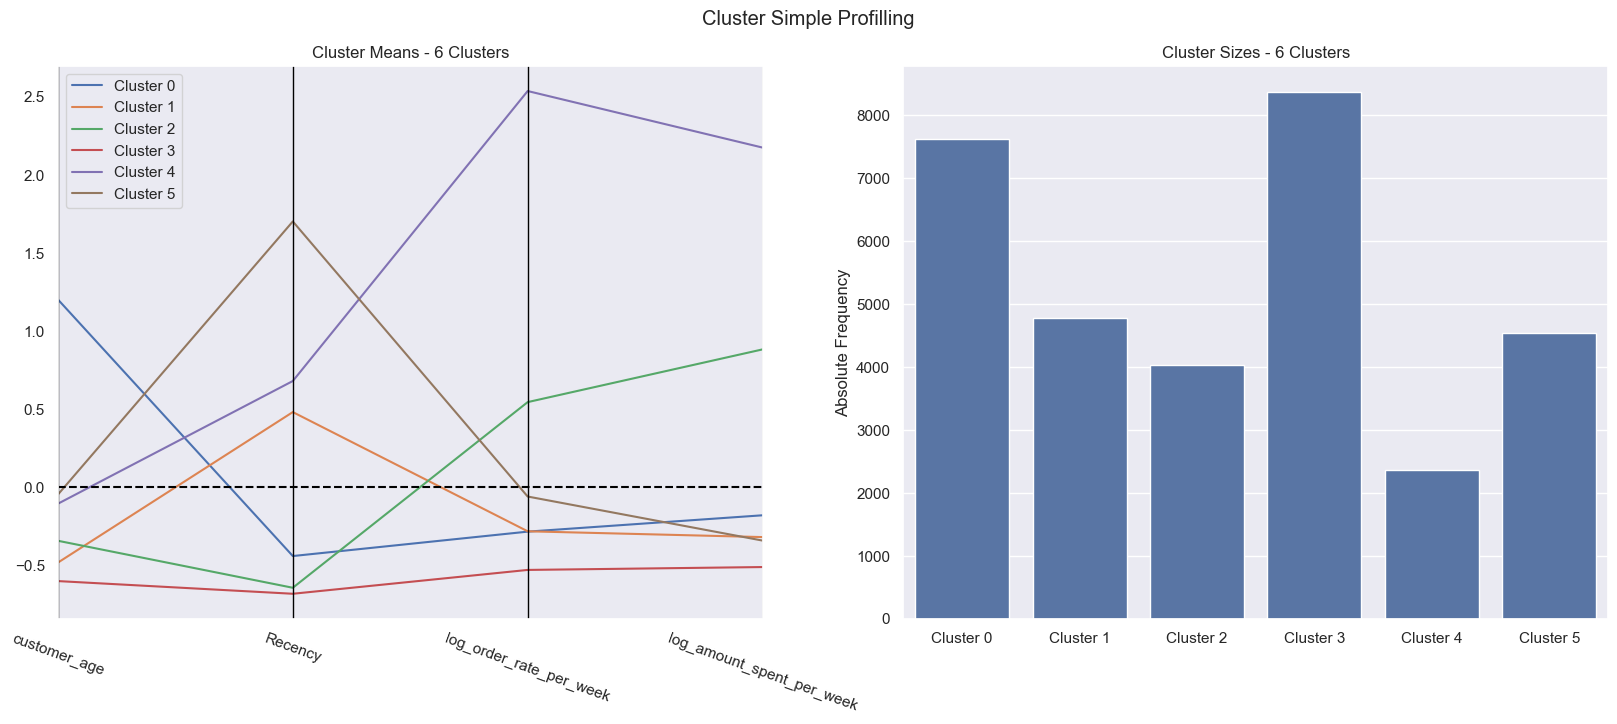

In [64]:
cluster_profiles(df_somh, ['som_hierar_labels'], (20,7))

### DBSCAN

In [66]:
df_socio4 = df[demographics_preferences]

#### Choosing the right number of eps

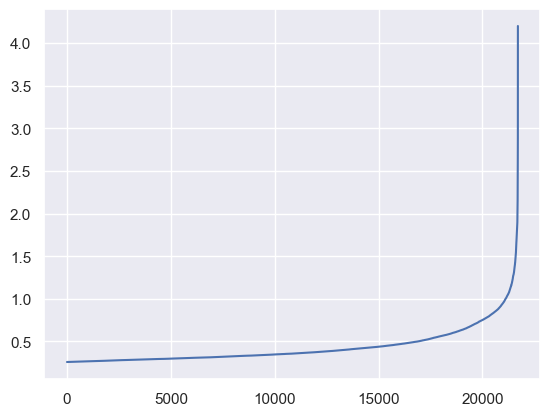

In [68]:
# Radius of cluster
neigh = NearestNeighbors(n_neighbors=27)
neigh.fit(df_socio4)
distances, _ = neigh.kneighbors(df_socio4)
distances = np.sort(distances[:, -1])
plt.plot(distances[10000:])
plt.show()

This plot above is typically used for determining an appropriate value for the epsilon (eps) parameter in DBSCAN clustering. The idea is to find the "elbow point" on the graph, which indicates the distance value where the curve transitions from a steep increase to a flatter slope. This point is a good candidate for the eps parameter, as it represents a natural clustering distance threshold in the data. 



We are going to zoom in as the right eps is not clear in the graph above. 

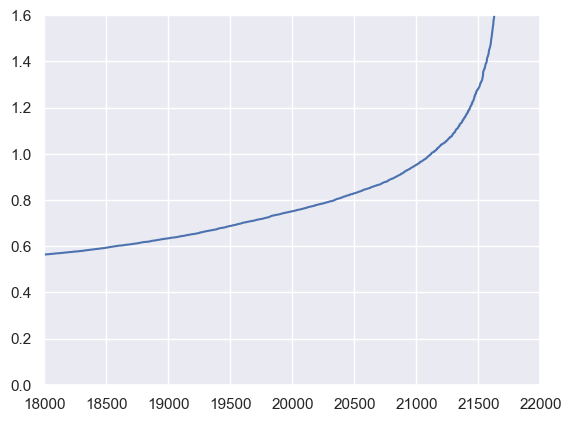

In [71]:
plt.plot(distances[10000:])
plt.axis([18000, 22000, 0,1.6])
plt.show()

After zooming in, we can see in the graph above that the elbow point is around 1.0, so that is the number that we are going to choose for eps.

#### Choosing the right number of min_samples

A function is going to be used to evaluate the values of 
the min_samples, with the selected eps value fixed, giving a view of the variation of the number of clusters 
and their respective noise.

In [75]:
for min_samples in range(2, 15):  
        dbscan = DBSCAN(eps=1.0, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(df_socio4)
            
        dbscan_n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
            
        n_noise = list(dbscan_labels).count(-1)
            
        if dbscan_n_clusters > 0:
            print(f"min_samples: {min_samples}, clusters: {dbscan_n_clusters}, noise:{n_noise}")

min_samples: 2, clusters: 7, noise:24
min_samples: 3, clusters: 4, noise:30
min_samples: 4, clusters: 3, noise:38
min_samples: 5, clusters: 2, noise:46
min_samples: 6, clusters: 1, noise:53
min_samples: 7, clusters: 1, noise:59
min_samples: 8, clusters: 1, noise:69
min_samples: 9, clusters: 2, noise:78
min_samples: 10, clusters: 1, noise:91
min_samples: 11, clusters: 1, noise:101
min_samples: 12, clusters: 1, noise:109
min_samples: 13, clusters: 1, noise:109
min_samples: 14, clusters: 1, noise:109


min_samples = 3, 4 and 5 might seem a reasonable choice. We are going to see the Silhouette Score for each of them

In [77]:
dbscan = DBSCAN(eps=1.0, min_samples=3, n_jobs=4)
dbscan_labels = dbscan.fit_predict(df_socio4)
score = silhouette_score(df_socio4.iloc[:, :-1], dbscan_labels)
print(f'Silhouette Score: {score}')
dbscan_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_clusters)



Silhouette Score: 0.6158930138835292
Number of estimated clusters : 5


In [78]:
dbscan = DBSCAN(eps=1.0, min_samples=4, n_jobs=4)
dbscan_labels = dbscan.fit_predict(df_socio4)
score = silhouette_score(df_socio4.iloc[:, :-1], dbscan_labels)
print(f'Silhouette Score: {score}')
dbscan_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_clusters)

Silhouette Score: 0.5491807772110465
Number of estimated clusters : 4


In [79]:
dbscan = DBSCAN(eps=1.0, min_samples=5, n_jobs=4)
dbscan_labels = dbscan.fit_predict(df_socio4)
score = silhouette_score(df_socio4.iloc[:, :-1], dbscan_labels)
print(f'Silhouette Score: {score}')
dbscan_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_clusters)

Silhouette Score: 0.622776909040176
Number of estimated clusters : 3


#### Final clustering

In [81]:
df_dbscan = pd.concat([df_socio4, pd.Series(dbscan_labels, name='dbscan_labels', index=df_socio4.index)], axis=1)

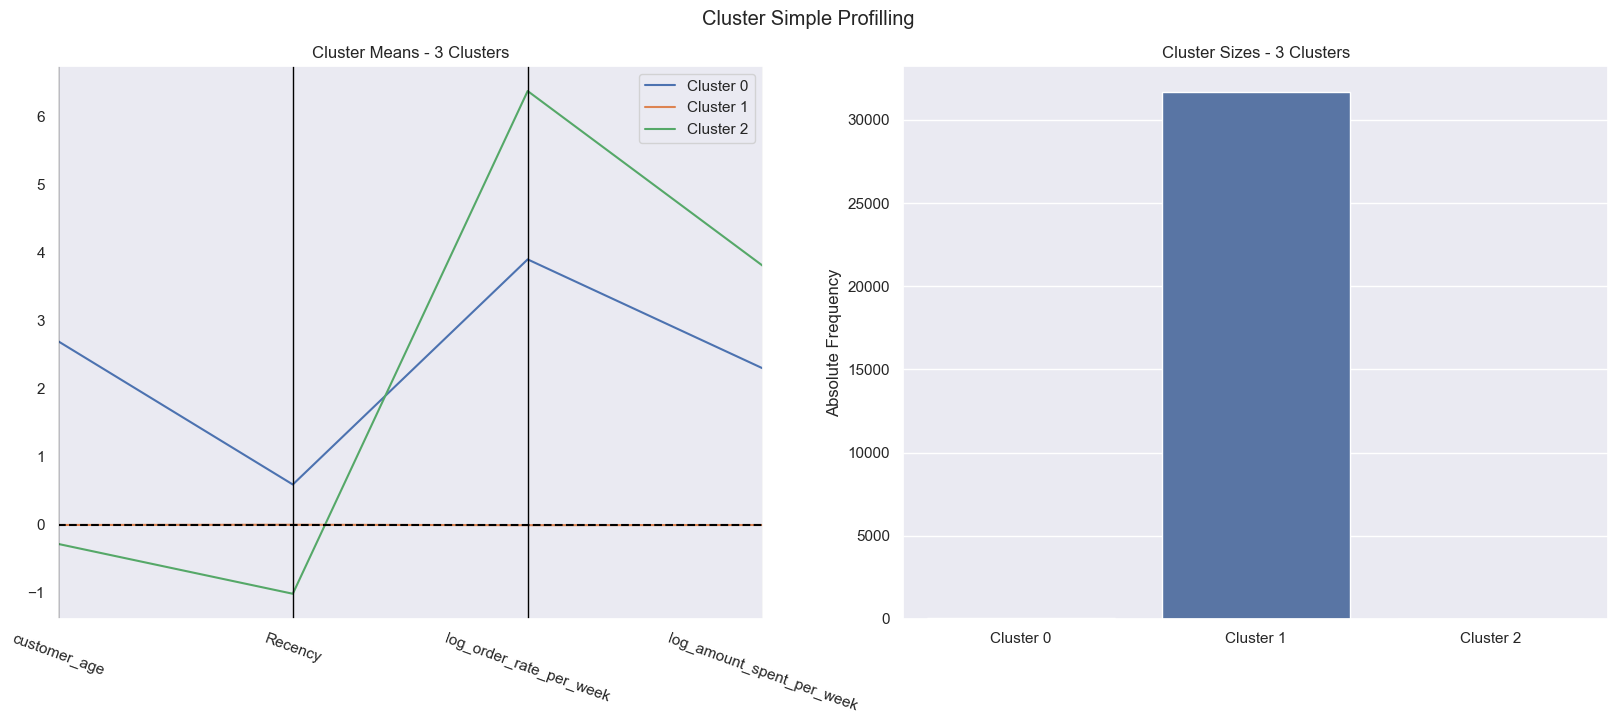

In [82]:
cluster_profiles(
    df = df_dbscan, 
    label_columns = ['dbscan_labels'], 
    figsize = (20, 7), 
)

### Combined_df

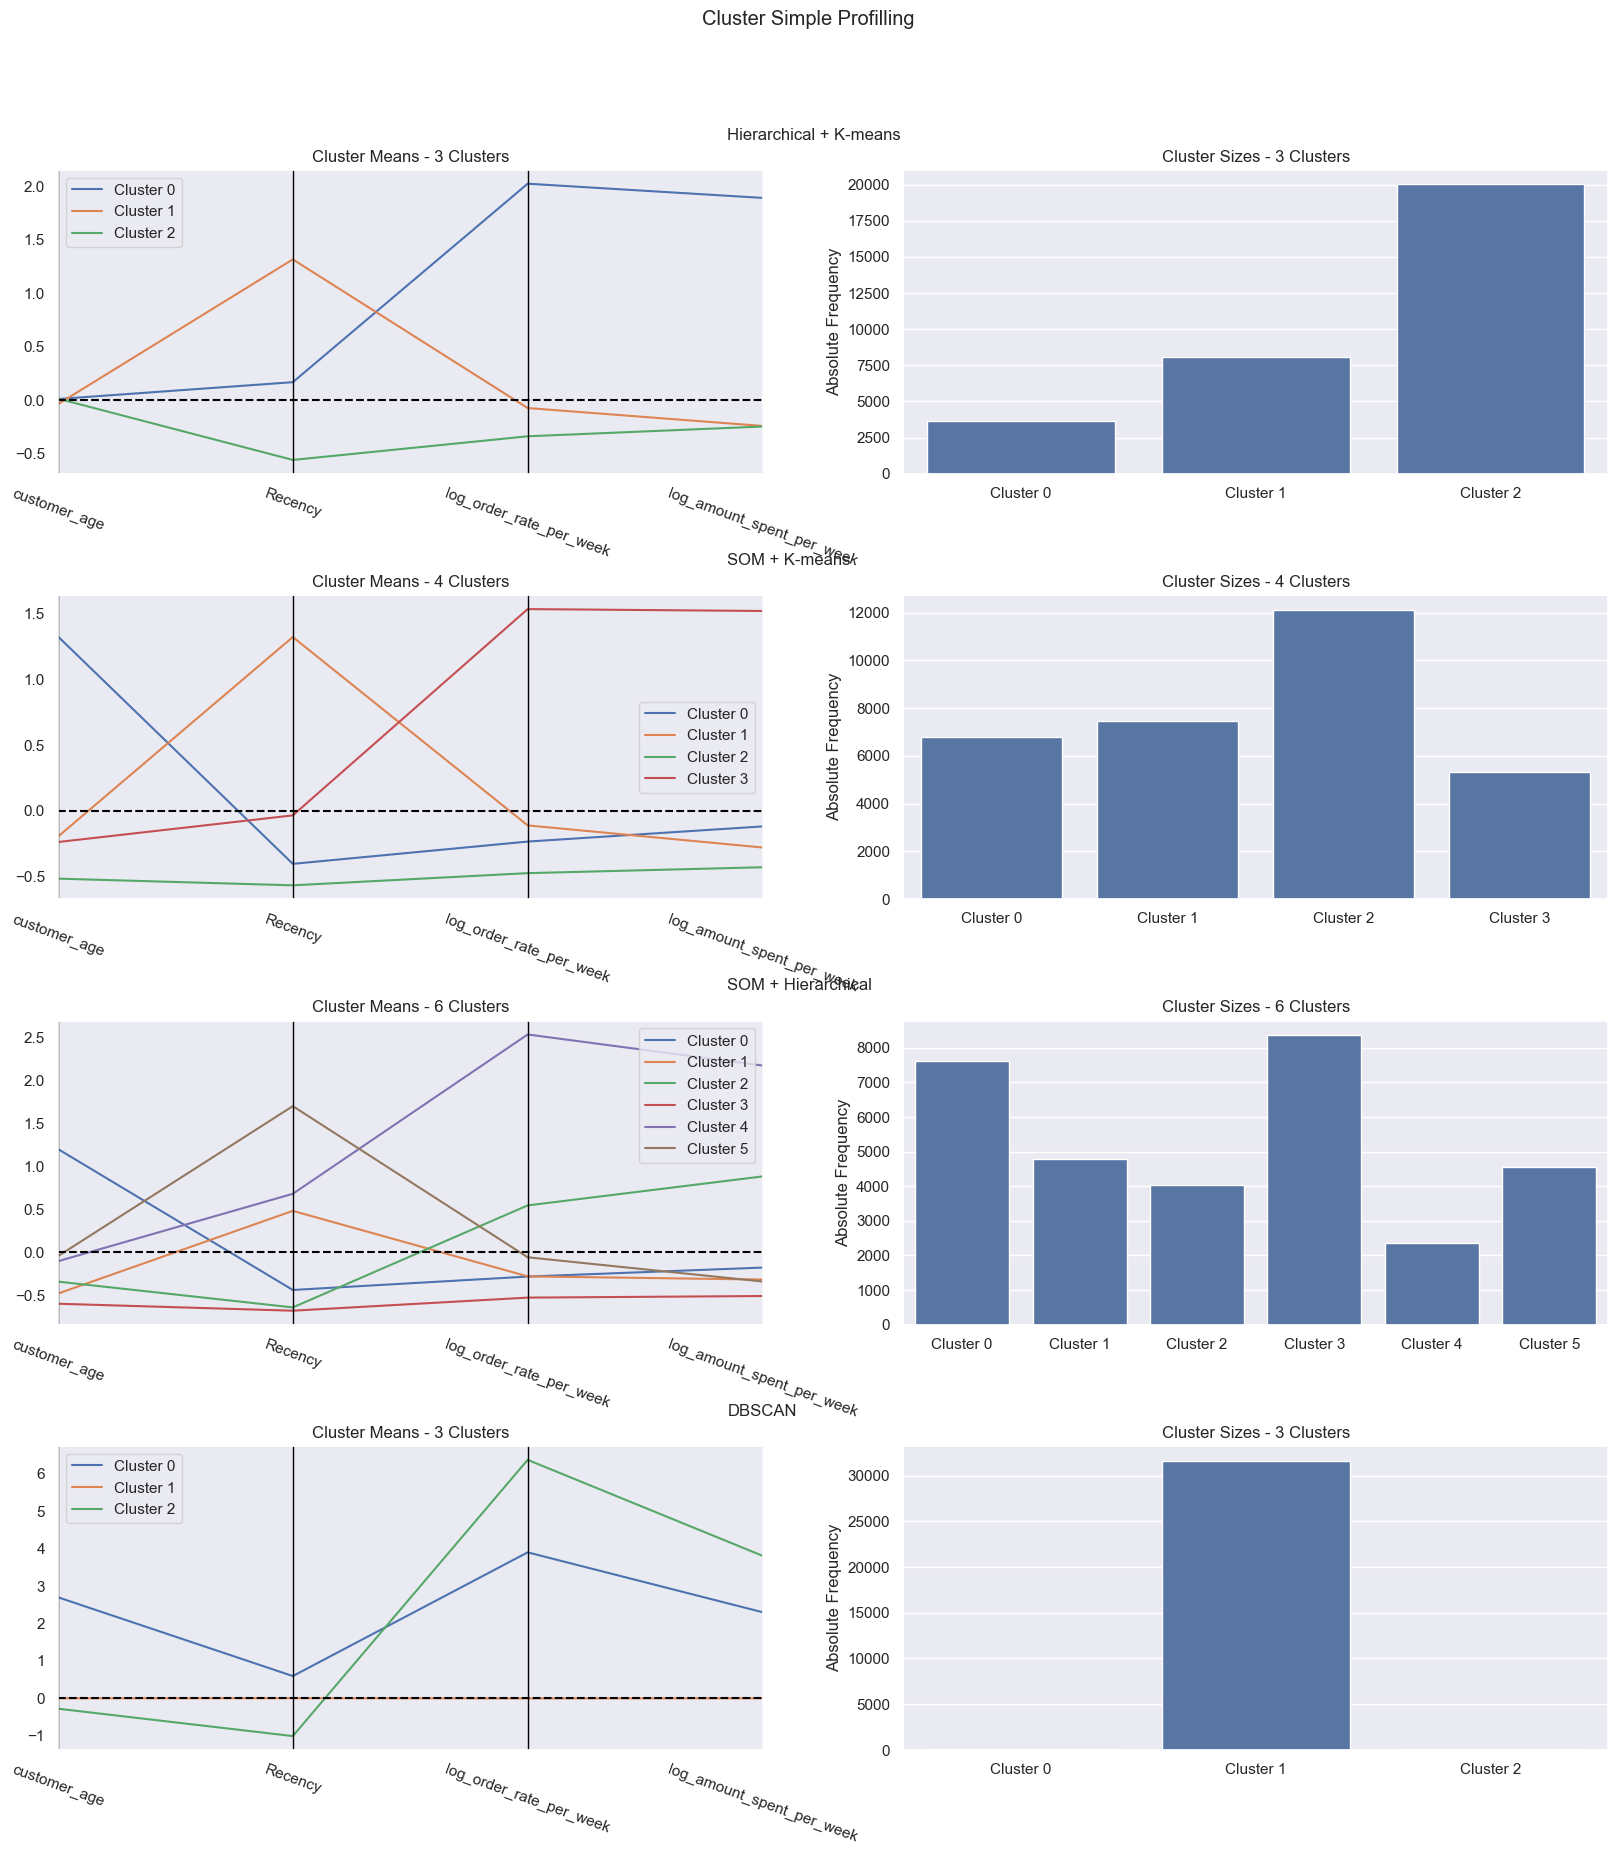

In [84]:
combined_df = pd.concat([df_socio1, df_somk_1, df_somh, df_dbscan], ignore_index=True)

label_columns = ['kmlust_labels', 'som_kmeans_labels', 'som_hierar_labels', 'dbscan_labels']

cluster_profiles(combined_df, label_columns, figsize=(20, 20),compar_titles = ["Hierarchical + K-means", "SOM + K-means", "SOM + Hierarchical", "DBSCAN"])

## 2.3 Segmentation 2 - Purchase_behavior 

### Hierachical + K-means

In [87]:
df_eng1 = df[purchase_behavior]

In [88]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst
    
def get_r2_scores(df, clusterer, min_k=2, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = r2(df, labels)
    return r2_clust


# Set up the clusterers
kmeans = KMeans(
    init='k-means++',
    n_init=20,
    random_state=42
)

hierarchical = AgglomerativeClustering(
    metric='euclidean'
)

In [89]:
# Obtaining the R² scores for each cluster solution on demographic variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_eng1, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df_eng1, hierarchical.set_params(linkage=linkage)
    )

pd.DataFrame(r2_scores)

,kmeans,complete,average,single,ward
2,0.329999,0.221912,0.107056,0.011853,0.286719
3,0.508832,0.309510,0.270238,0.212102,0.491700
4,0.617674,0.325966,0.504689,0.363146,0.573963
5,0.683311,0.413692,0.624408,0.450921,0.640899
6,0.735748,0.523049,0.642856,0.451062,0.699835
7,0.769879,0.584385,0.713890,0.451146,0.738126
8,0.796416,0.654003,0.718439,0.451237,0.764474
9,0.816777,0.660790,0.742094,0.489664,0.785290


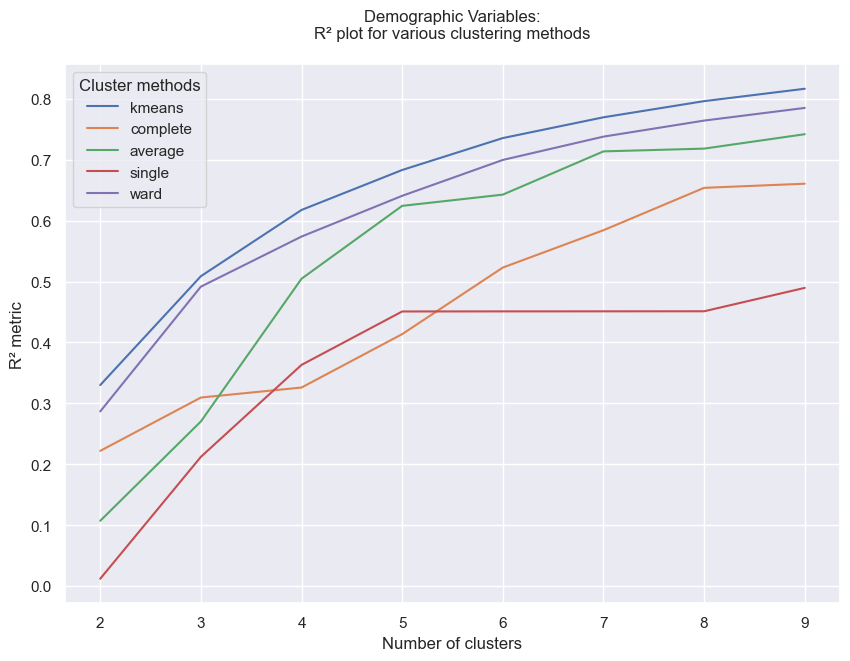

In [90]:
# Visualizing the R² scores for each cluster solution on demographic variables
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("Demographic Variables:\nR² plot for various clustering methods\n")
plt.legend(title="Cluster methods")
plt.xlabel("Number of clusters")
plt.ylabel("R² metric")
plt.show()

Based on the R² plot the correct number of clusters might be 3 or 4, but the choice isn't clear.

In [92]:
kmclust = KMeans(n_clusters=4, init='k-means++', n_init=15, random_state=1)
kmclust.fit(df_eng1)

KMeans(n_clusters=4, n_init=15, random_state=1)

We are going to do the silhouette_score to decide the final number of clusters. 

For n_clusters = 2, the average silhouette_score is : 0.3195787883955829
For n_clusters = 3, the average silhouette_score is : 0.3286975741754766
For n_clusters = 4, the average silhouette_score is : 0.3331778371689296
For n_clusters = 5, the average silhouette_score is : 0.34312772357956584
For n_clusters = 6, the average silhouette_score is : 0.3580433330816708
For n_clusters = 7, the average silhouette_score is : 0.3444071785893973
For n_clusters = 8, the average silhouette_score is : 0.352332972119224
For n_clusters = 9, the average silhouette_score is : 0.35087622486803394
For n_clusters = 10, the average silhouette_score is : 0.35254606236346636


<Figure size 1300x700 with 0 Axes>

<Figure size 1300x700 with 0 Axes>

<Figure size 1300x700 with 0 Axes>

<Figure size 1300x700 with 0 Axes>

<Figure size 1300x700 with 0 Axes>

<Figure size 1300x700 with 0 Axes>

<Figure size 1300x700 with 0 Axes>

<Figure size 1300x700 with 0 Axes>

<Figure size 1300x700 with 0 Axes>

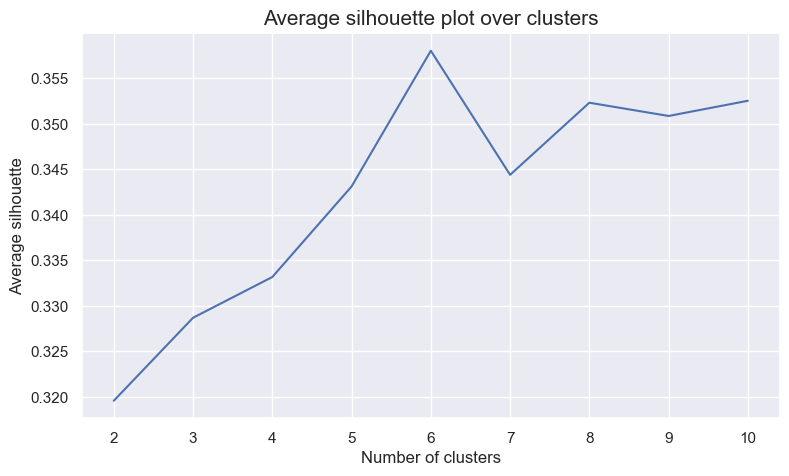

In [94]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

range_clusters = range(1, 11)

# Storing average silhouette metric
avg_silhouette = []
for nclus in range_clusters:
    # Skip nclus == 1
    if nclus == 1:
        continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(df_eng1)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(df_eng1, cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

# The average silhouette plot
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(range_clusters[1:], ## Plot X-axis; Why range_clusters[1:] ? Remember we skipped k=1 in the cell above
         avg_silhouette)     ## Plot Y-axis

plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

Based on the graph above the choice is more clear. We are going to choose 3 clusters. The gain in silhouette score between 3 and 4 is very low. With 3 clusters, the results are simpler to interpret and visualize.

In [96]:
# Re-running the Hierarchical clustering based on the correct number of clusters
kmclust = KMeans(n_clusters=3, init='k-means++', n_init=15, random_state=1)
kmclust_labels = kmclust.fit_predict(df_eng1)
df_eng1['kmlust_labels'] = kmclust_labels

df_eng1

,average_product_price,chain_percentage,log_vendor_count,kmlust_labels
0,0.499788,0.957495,-0.306522,2
1,-0.734841,0.957495,-1.098006,2
2,0.725499,-0.334027,-0.306522,1
3,0.865613,-1.625548,-0.306522,1
4,1.204057,-1.625548,-0.306522,1
...,...,...,...,...
31706,2.580526,0.957495,-1.098006,2
31707,2.580526,-1.625548,-1.098006,1
31708,2.518857,0.957495,-1.098006,2
31709,1.097985,-1.625548,-1.098006,1


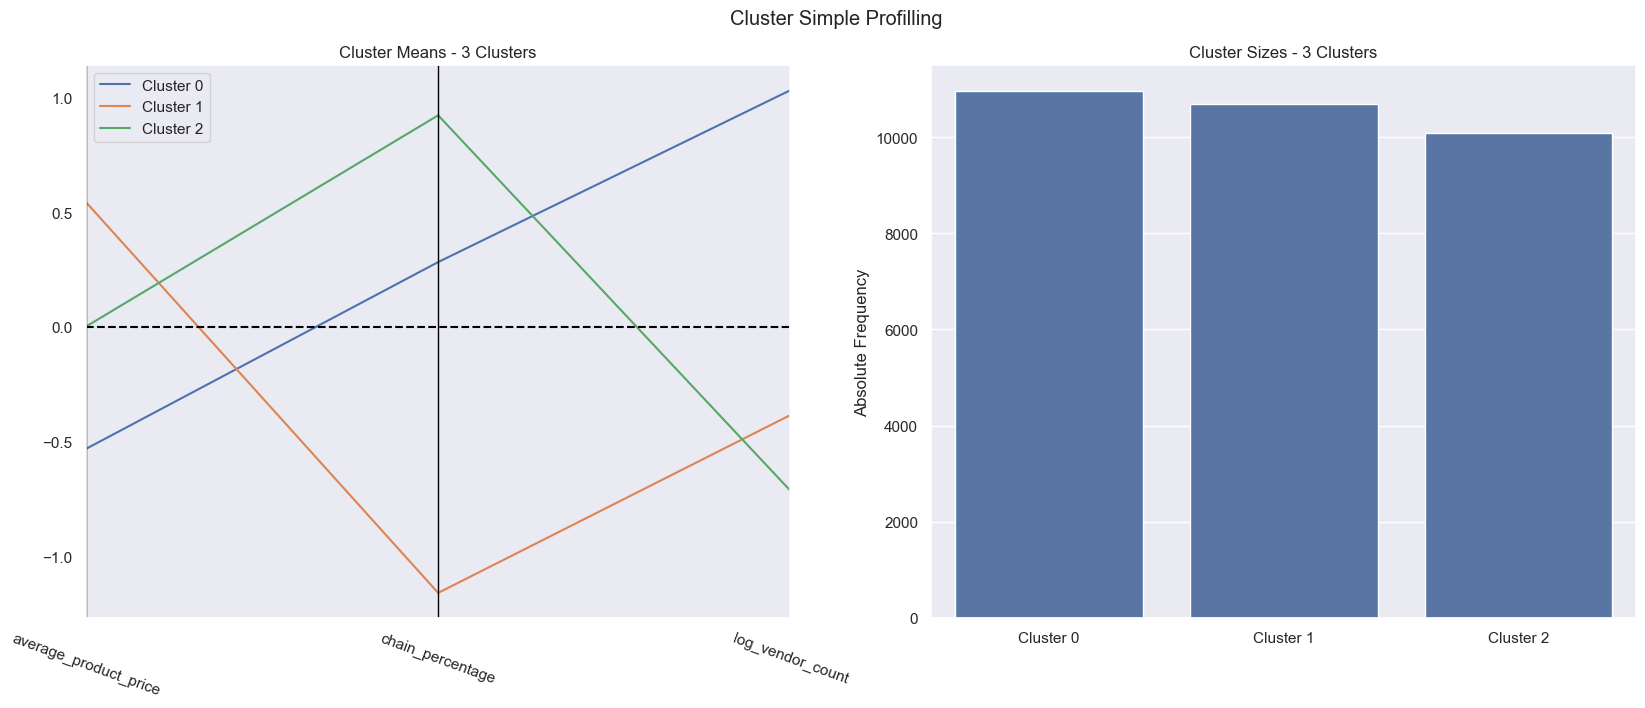

In [97]:
cluster_profiles(df_eng1, ['kmlust_labels'], (20,7))

### SOM + K-means

In [99]:
df_eng2 = df[purchase_behavior]

#### SOM Training

In [101]:
np.random.seed(80)

sm = sompy.SOMFactory().build(
    df_eng2.values, 
    mapsize=[10, 10], 
    initialization='random', 
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=purchase_behavior
)
sm.train(n_job=1, verbose='info', train_rough_len=120, train_finetune_len=120)

 Training...
 random_initialization took: 0.001000 seconds
 Rough training...
 radius_ini: 4.000000 , radius_final: 1.000000, trainlen: 120

 epoch: 1 ---> elapsed time:  0.386000, quantization error: 0.665714

 epoch: 2 ---> elapsed time:  0.231000, quantization error: 1.575720

 epoch: 3 ---> elapsed time:  0.197000, quantization error: 1.492298

 epoch: 4 ---> elapsed time:  0.134000, quantization error: 1.469290

 epoch: 5 ---> elapsed time:  0.173000, quantization error: 1.456832

 epoch: 6 ---> elapsed time:  0.154000, quantization error: 1.445546

 epoch: 7 ---> elapsed time:  0.148000, quantization error: 1.436030

 epoch: 8 ---> elapsed time:  0.191000, quantization error: 1.431510

 epoch: 9 ---> elapsed time:  0.117000, quantization error: 1.428205

 epoch: 10 ---> elapsed time:  0.179000, quantization error: 1.425162

 epoch: 11 ---> elapsed time:  0.173000, quantization error: 1.422227

 epoch: 12 ---> elapsed time:  0.170000, quantization error: 1.419377

 epoch: 13 ---> 

#### Choosing the best number of clusters

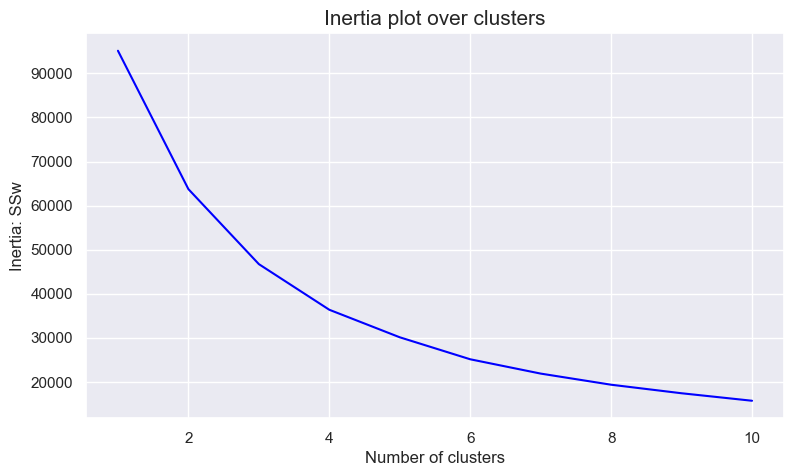

In [103]:
inertia = []
for n_clus in range(1,11): 
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=20, random_state=80)
    kmclust.fit(df_eng2)
    inertia.append(kmclust.inertia_)

plt.figure(figsize=(9,5))
plt.plot(range(1,11),inertia,color = 'blue')
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

Beyond 3 clusters, the decrease in inertia slows down, which suggests diminishing returns for adding more clusters.

The "elbow point" appears to be at 3 clusters, where the rate of improvement in inertia reduction becomes less pronounced.

#### HitMapView

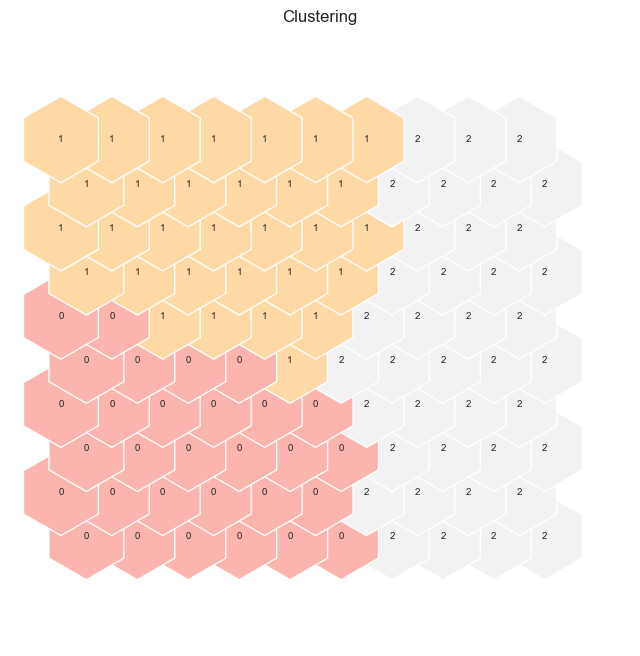

In [106]:
kmeans = KMeans(n_clusters=3,init='k-means++', n_init=20, random_state=42)
nodeclus_labels = kmeans.fit_predict(sm.codebook.matrix)
sm.cluster_labels = nodeclus_labels  # setting the cluster labels of sompy

hits = HitMapView(8,8,"Clustering", text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

#### Final clustering

In [108]:
nodes = sm.codebook.matrix

df_somk = pd.DataFrame(nodes, columns=purchase_behavior)
df_somk['som_kmeans_labels'] = nodeclus_labels
df_somk


,average_product_price,chain_percentage,log_vendor_count,som_kmeans_labels
0,1.543260,-1.228954,-0.779392,2
1,1.374869,-0.761434,-0.631249,2
2,1.311735,-0.181550,-0.569576,2
3,1.293052,0.399470,-0.724455,1
4,1.364089,0.770340,-0.893945,1
...,...,...,...,...
95,0.297510,-0.329754,1.156398,0
96,0.075766,-0.234577,1.452817,0
97,-0.245351,0.036324,1.485774,0
98,-0.605436,0.305982,1.612785,0


In [109]:
bmus_map = sm.find_bmu(df_eng2.values)[0]  #get bmus for each observation in df

In [110]:
df_bmus = pd.DataFrame(
    np.concatenate((df_eng2, np.expand_dims(bmus_map,1)), axis=1),
    index=df_eng2.index, columns=np.append(df_eng2.columns,"BMU")
)
df_bmus

,average_product_price,chain_percentage,log_vendor_count,BMU
0,0.499788,0.957495,-0.306522,25.0
1,-0.734841,0.957495,-1.098006,9.0
2,0.725499,-0.334027,-0.306522,33.0
3,0.865613,-1.625548,-0.306522,30.0
4,1.204057,-1.625548,-0.306522,20.0
...,...,...,...,...
31706,2.580526,0.957495,-1.098006,4.0
31707,2.580526,-1.625548,-1.098006,10.0
31708,2.518857,0.957495,-1.098006,4.0
31709,1.097985,-1.625548,-1.098006,20.0


In [111]:
df_somk_1 = df_bmus.merge(df_somk['som_kmeans_labels'], 'left', left_on="BMU", right_index=True)

df_somk_1.drop('BMU', axis=1, inplace=True)

In [112]:
df_somk_1.groupby('som_kmeans_labels')[purchase_behavior].mean()

,average_product_price,chain_percentage,log_vendor_count
som_kmeans_labels,,,
0,-0.500106,0.320997,1.136942
1,0.035504,0.882197,-0.639384
2,0.413329,-1.151493,-0.392593


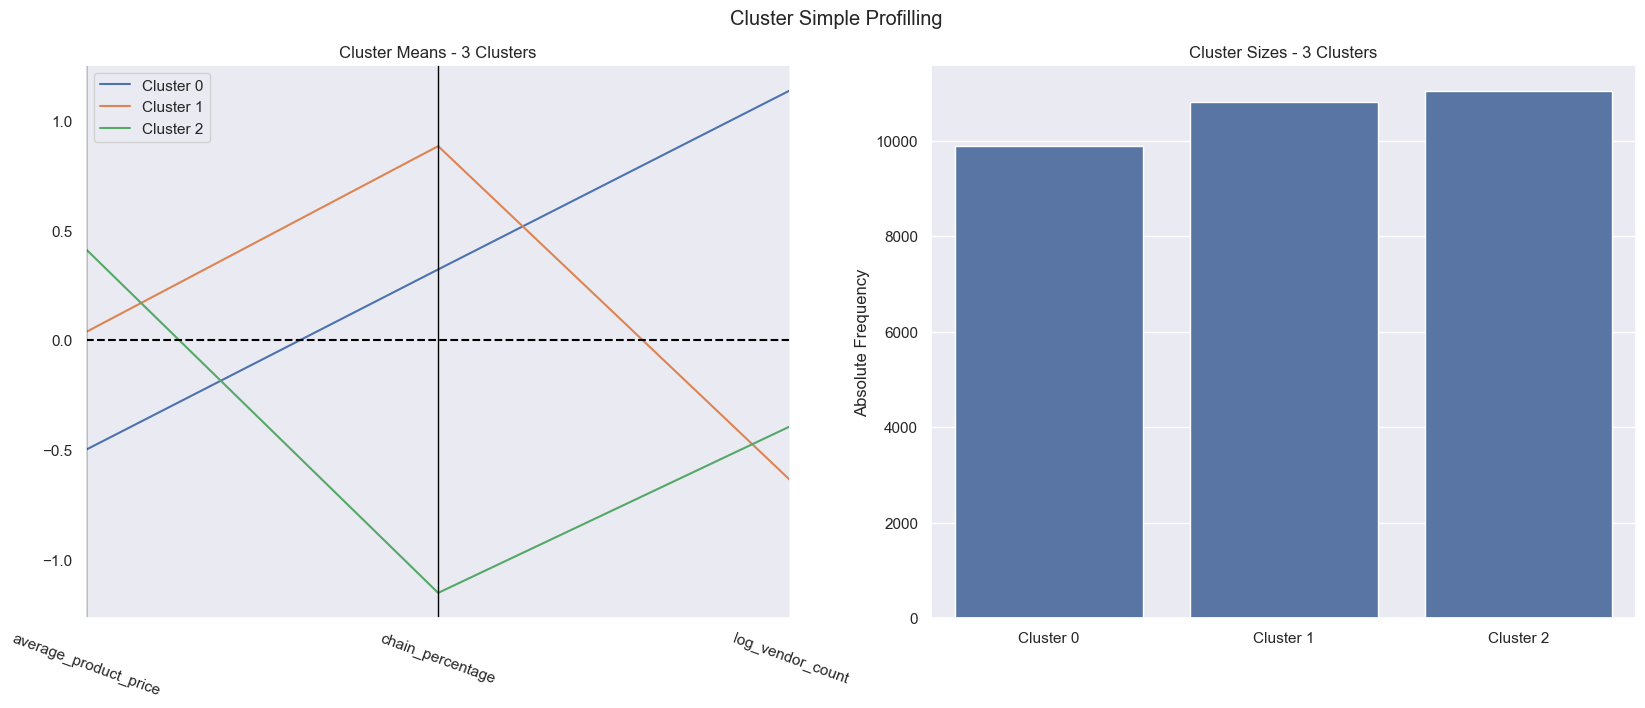

In [113]:
cluster_profiles(df_somk_1, ['som_kmeans_labels'], (20,7))

### SOM + Hierarquical

In [115]:
df_eng3 = df[purchase_behavior]

#### SOM Training

In [117]:
np.random.seed(80)

sm = sompy.SOMFactory().build(
    df_eng3.values, 
    mapsize=[10, 10], 
    initialization='random', 
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=purchase_behavior
)
sm.train(n_job=1, verbose='info', train_rough_len=120, train_finetune_len=120)

 Training...
 random_initialization took: 0.001000 seconds
 Rough training...
 radius_ini: 4.000000 , radius_final: 1.000000, trainlen: 120

 epoch: 1 ---> elapsed time:  0.171000, quantization error: 0.665714

 epoch: 2 ---> elapsed time:  0.172000, quantization error: 1.575720

 epoch: 3 ---> elapsed time:  0.194000, quantization error: 1.492298

 epoch: 4 ---> elapsed time:  0.160000, quantization error: 1.469290

 epoch: 5 ---> elapsed time:  0.155000, quantization error: 1.456832

 epoch: 6 ---> elapsed time:  0.235000, quantization error: 1.445546

 epoch: 7 ---> elapsed time:  0.153000, quantization error: 1.436030

 epoch: 8 ---> elapsed time:  0.212000, quantization error: 1.431510

 epoch: 9 ---> elapsed time:  0.159000, quantization error: 1.428205

 epoch: 10 ---> elapsed time:  0.228000, quantization error: 1.425162

 epoch: 11 ---> elapsed time:  0.148000, quantization error: 1.422227

 epoch: 12 ---> elapsed time:  0.174000, quantization error: 1.419377

 epoch: 13 ---> 

#### Choosing the best number of clusters with Hierarchical

In [119]:
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, metric=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(df_eng3)

array([31710, 31709, 27661, ...,     5,     2,     0], dtype=int64)

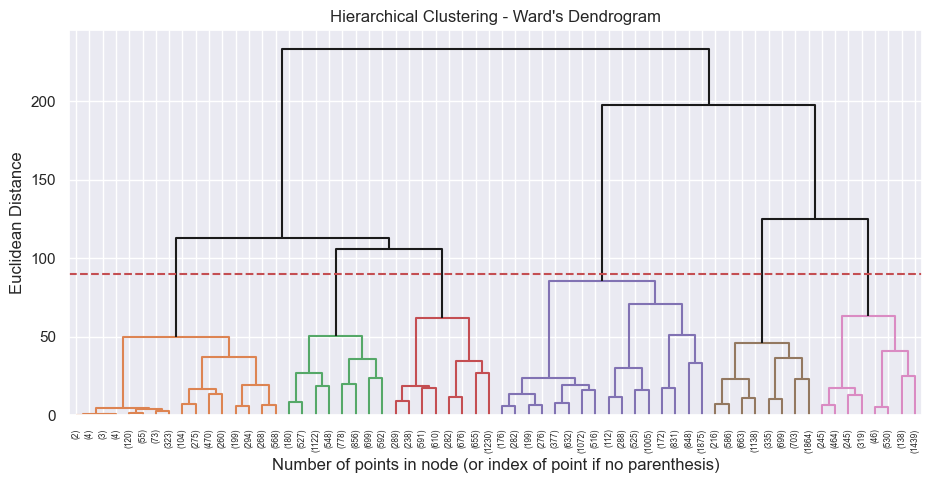

In [120]:
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 90
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram')
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance')
plt.show()

The threshold (red line) intersects just below a noticeable "gap" in the dendrogram.
Above this threshold, the vertical distances between clusters are much larger, meaning clusters are more distinct.

Based on this analysis 6 is the right choice.

#### HitMapView

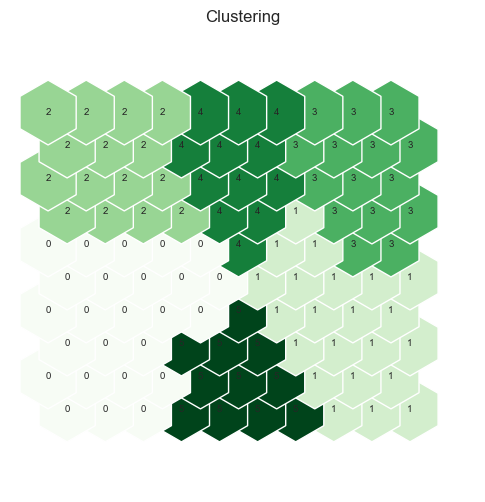

In [123]:
hierclust = AgglomerativeClustering(n_clusters=6, linkage='ward')
node_hier_label= hierclust.fit_predict(sm.codebook.matrix)
sm.cluster_labels = node_hier_label  # setting the cluster labels of sompy

hits  = HitMapView(6,6,"Clustering",text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap=cm.Greens)

plt.show()

#### Final Clustering

In [125]:
nodes = sm.codebook.matrix

hnodes = pd.DataFrame(nodes, columns=purchase_behavior)
hnodes['som_hierar_labels'] = node_hier_label
hnodes

,average_product_price,chain_percentage,log_vendor_count,som_hierar_labels
0,1.543260,-1.228954,-0.779392,3
1,1.374869,-0.761434,-0.631249,3
2,1.311735,-0.181550,-0.569576,3
3,1.293052,0.399470,-0.724455,4
4,1.364089,0.770340,-0.893945,4
...,...,...,...,...
95,0.297510,-0.329754,1.156398,5
96,0.075766,-0.234577,1.452817,5
97,-0.245351,0.036324,1.485774,0
98,-0.605436,0.305982,1.612785,0


In [126]:
bmus_ = sm.find_bmu(df_eng3.values)[0]

In [127]:
df_bmus = pd.DataFrame(
    np.concatenate((df_eng3, np.expand_dims(bmus_,1)), axis=1),
    index=df_eng3.index, columns=np.append(df_eng3.columns,"BMU")
)
df_bmus

,average_product_price,chain_percentage,log_vendor_count,BMU
0,0.499788,0.957495,-0.306522,25.0
1,-0.734841,0.957495,-1.098006,9.0
2,0.725499,-0.334027,-0.306522,33.0
3,0.865613,-1.625548,-0.306522,30.0
4,1.204057,-1.625548,-0.306522,20.0
...,...,...,...,...
31706,2.580526,0.957495,-1.098006,4.0
31707,2.580526,-1.625548,-1.098006,10.0
31708,2.518857,0.957495,-1.098006,4.0
31709,1.097985,-1.625548,-1.098006,20.0


In [128]:
# Get cluster labels for each observation
df_somh = df_bmus.merge(hnodes['som_hierar_labels'], 'left', left_on="BMU", right_index=True)

df_somh.drop('BMU', axis=1, inplace=True)

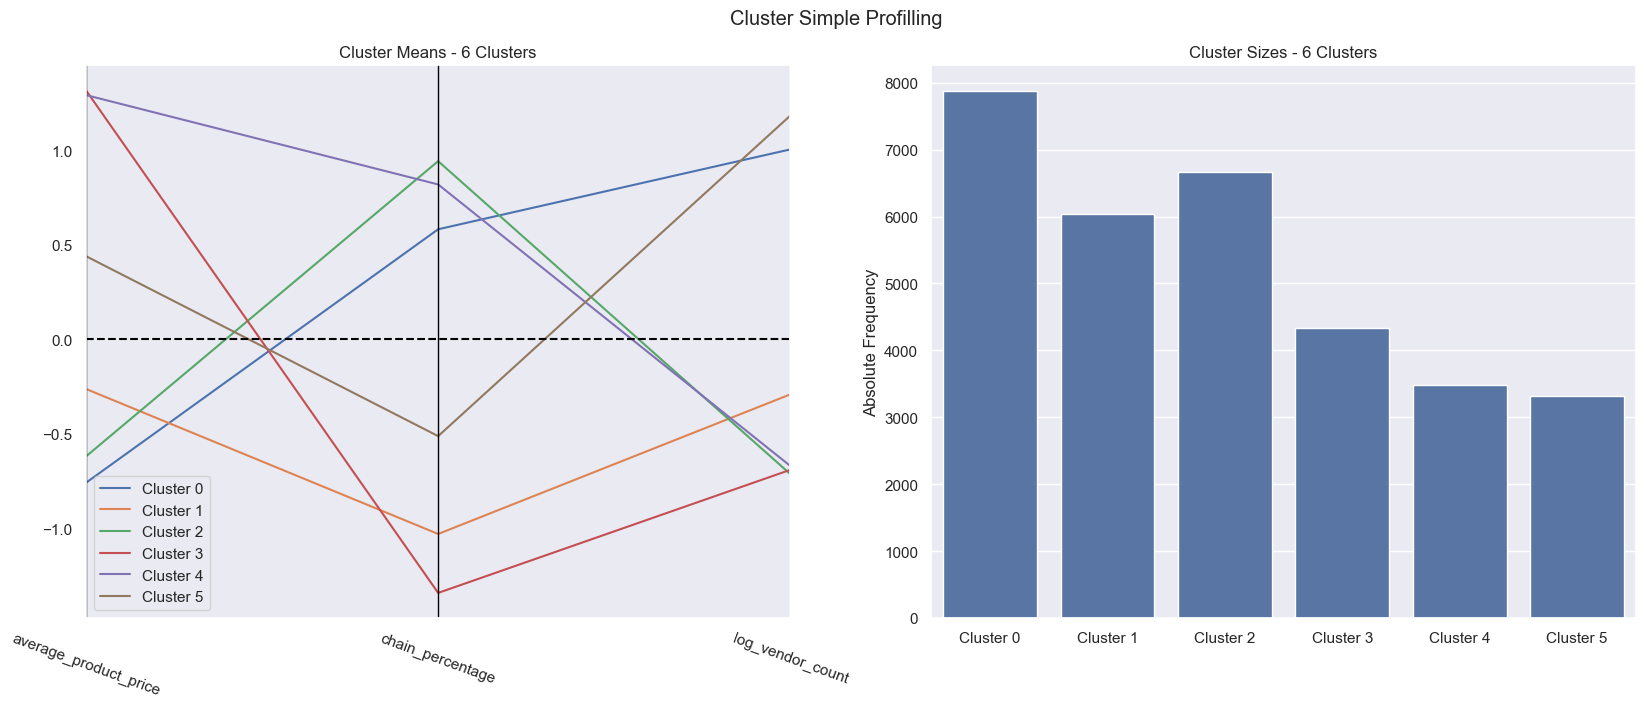

In [129]:
cluster_profiles(df_somh, ['som_hierar_labels'], (20,7))

### DBSCAN

In [131]:
df_eng4 = df[purchase_behavior]

#### Choosing the right number of eps

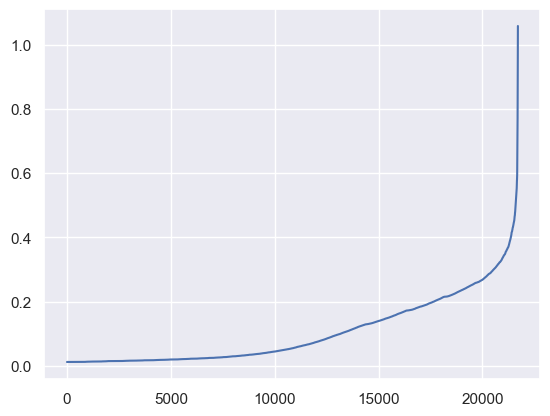

In [133]:
# Radius of cluster
neigh = NearestNeighbors(n_neighbors=27)
neigh.fit(df_eng4)
distances, _ = neigh.kneighbors(df_eng4)
distances = np.sort(distances[:, -1])
plt.plot(distances[10000:])
plt.show()

One more time the right eps isn't clear in the graph above.

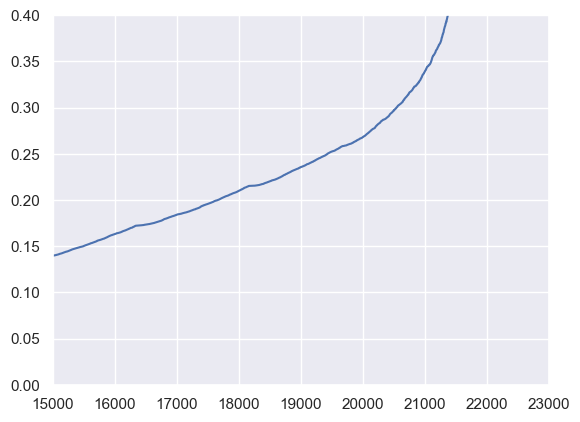

In [135]:
plt.plot(distances[10000:])
plt.axis([15000, 23000, 0,0.4])
plt.show()

After zooming in we can see that the "elbow" appears to be somewhere around the 0.25 - 0.30 range on the y-axis, which suggests that eps might be in this range. There isn't a choice that is 100% right. We are going to choose eps= 0.30 but it is a little bit subjective.

#### Choosing the right number of min_samples

In [138]:
for min_samples in range(2, 15):  
        dbscan = DBSCAN(eps=0.30, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(df_eng4)
            
        dbscan_n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
            
        n_noise = list(dbscan_labels).count(-1)
            
        if dbscan_n_clusters > 0:
            print(f"min_samples: {min_samples}, clusters: {dbscan_n_clusters}, noise:{n_noise}")

min_samples: 2, clusters: 10, noise:19
min_samples: 3, clusters: 10, noise:19
min_samples: 4, clusters: 8, noise:25
min_samples: 5, clusters: 8, noise:26
min_samples: 6, clusters: 8, noise:33
min_samples: 7, clusters: 8, noise:40
min_samples: 8, clusters: 8, noise:44
min_samples: 9, clusters: 8, noise:52
min_samples: 10, clusters: 8, noise:66
min_samples: 11, clusters: 8, noise:77
min_samples: 12, clusters: 8, noise:101
min_samples: 13, clusters: 9, noise:114
min_samples: 14, clusters: 8, noise:134


While increasing min_samples beyond 4 maintains the same number of clusters, it significantly increases noise points:

 - min_samples = 6 results in 33 noise points.
 - min_samples = 10 results in 66 noise points.
 - min_samples = 12 results in 101 noise points.
   
By choosing min_samples = 4, we include more borderline points in clusters while still maintaining clear groupings.

Smaller min_samples values lower the density threshold for forming clusters, resulting in additional, less meaningful clusters.

In [140]:
dbscan = DBSCAN(eps=0.30, min_samples= 4,n_jobs=4)
dbscan_labels = dbscan.fit_predict(df_eng4)

dbscan_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_clusters)

Number of estimated clusters : 9


#### Final clustering

In [142]:
df_dbscan = pd.concat([df_eng4, pd.Series(dbscan_labels, name='dbscan_labels', index=df_eng4.index)], axis=1)

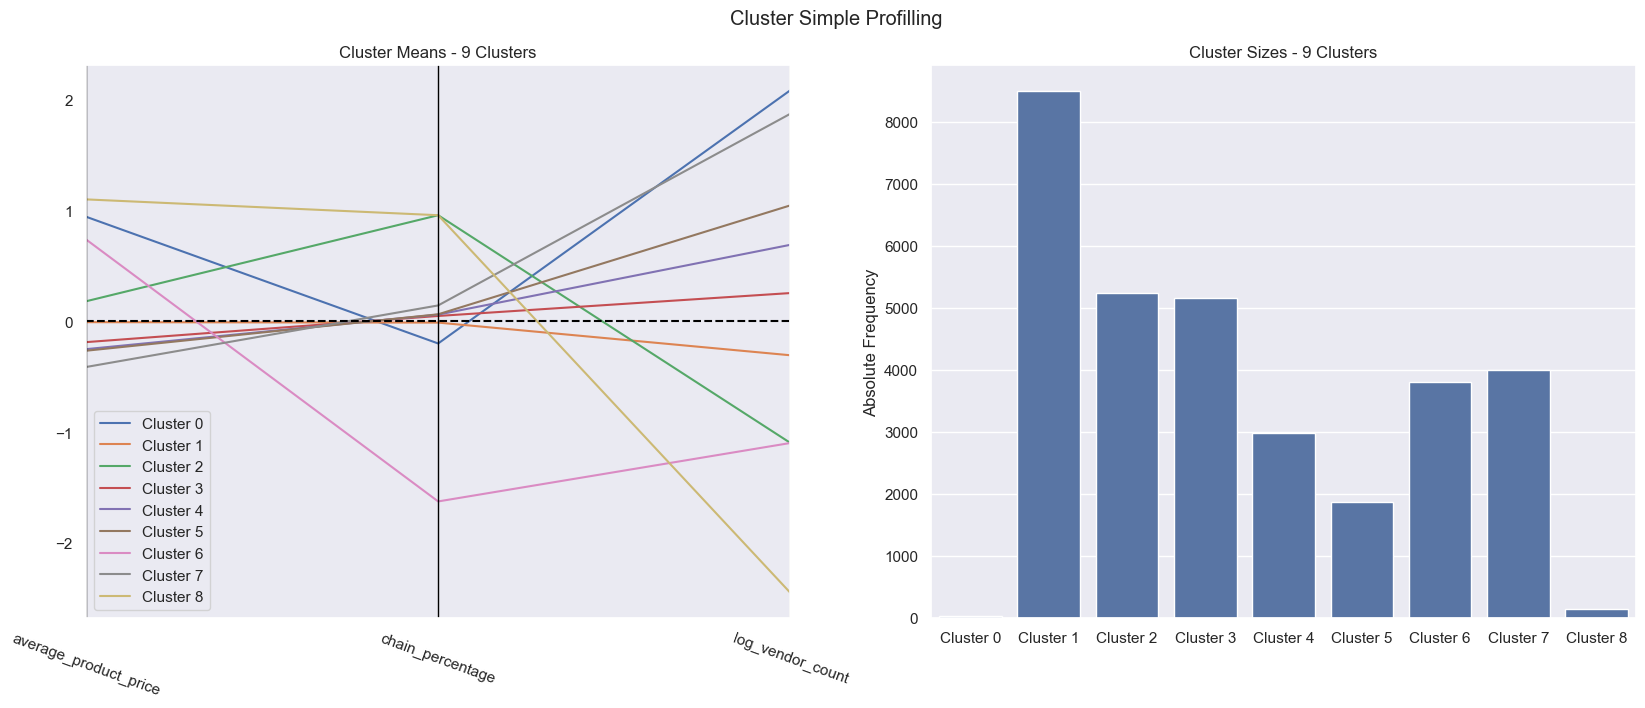

In [143]:
cluster_profiles(
    df = df_dbscan, 
    label_columns = ['dbscan_labels'], 
    figsize = (20, 7), 
    
)

In [144]:
df_dbscan.groupby('dbscan_labels')[purchase_behavior].mean()

,average_product_price,chain_percentage,log_vendor_count
dbscan_labels,,,
-1,0.944345,-0.199972,2.086035
0,-0.007708,-0.011587,-0.306522
1,0.180414,0.957495,-1.098006
2,-0.188027,0.048366,0.255046
3,-0.251489,0.060429,0.690631
4,-0.265657,0.063337,1.046531
5,0.739783,-1.625548,-1.098006
6,-0.412630,0.143336,1.873621
7,1.100452,0.957495,-2.451058


### Combined_df

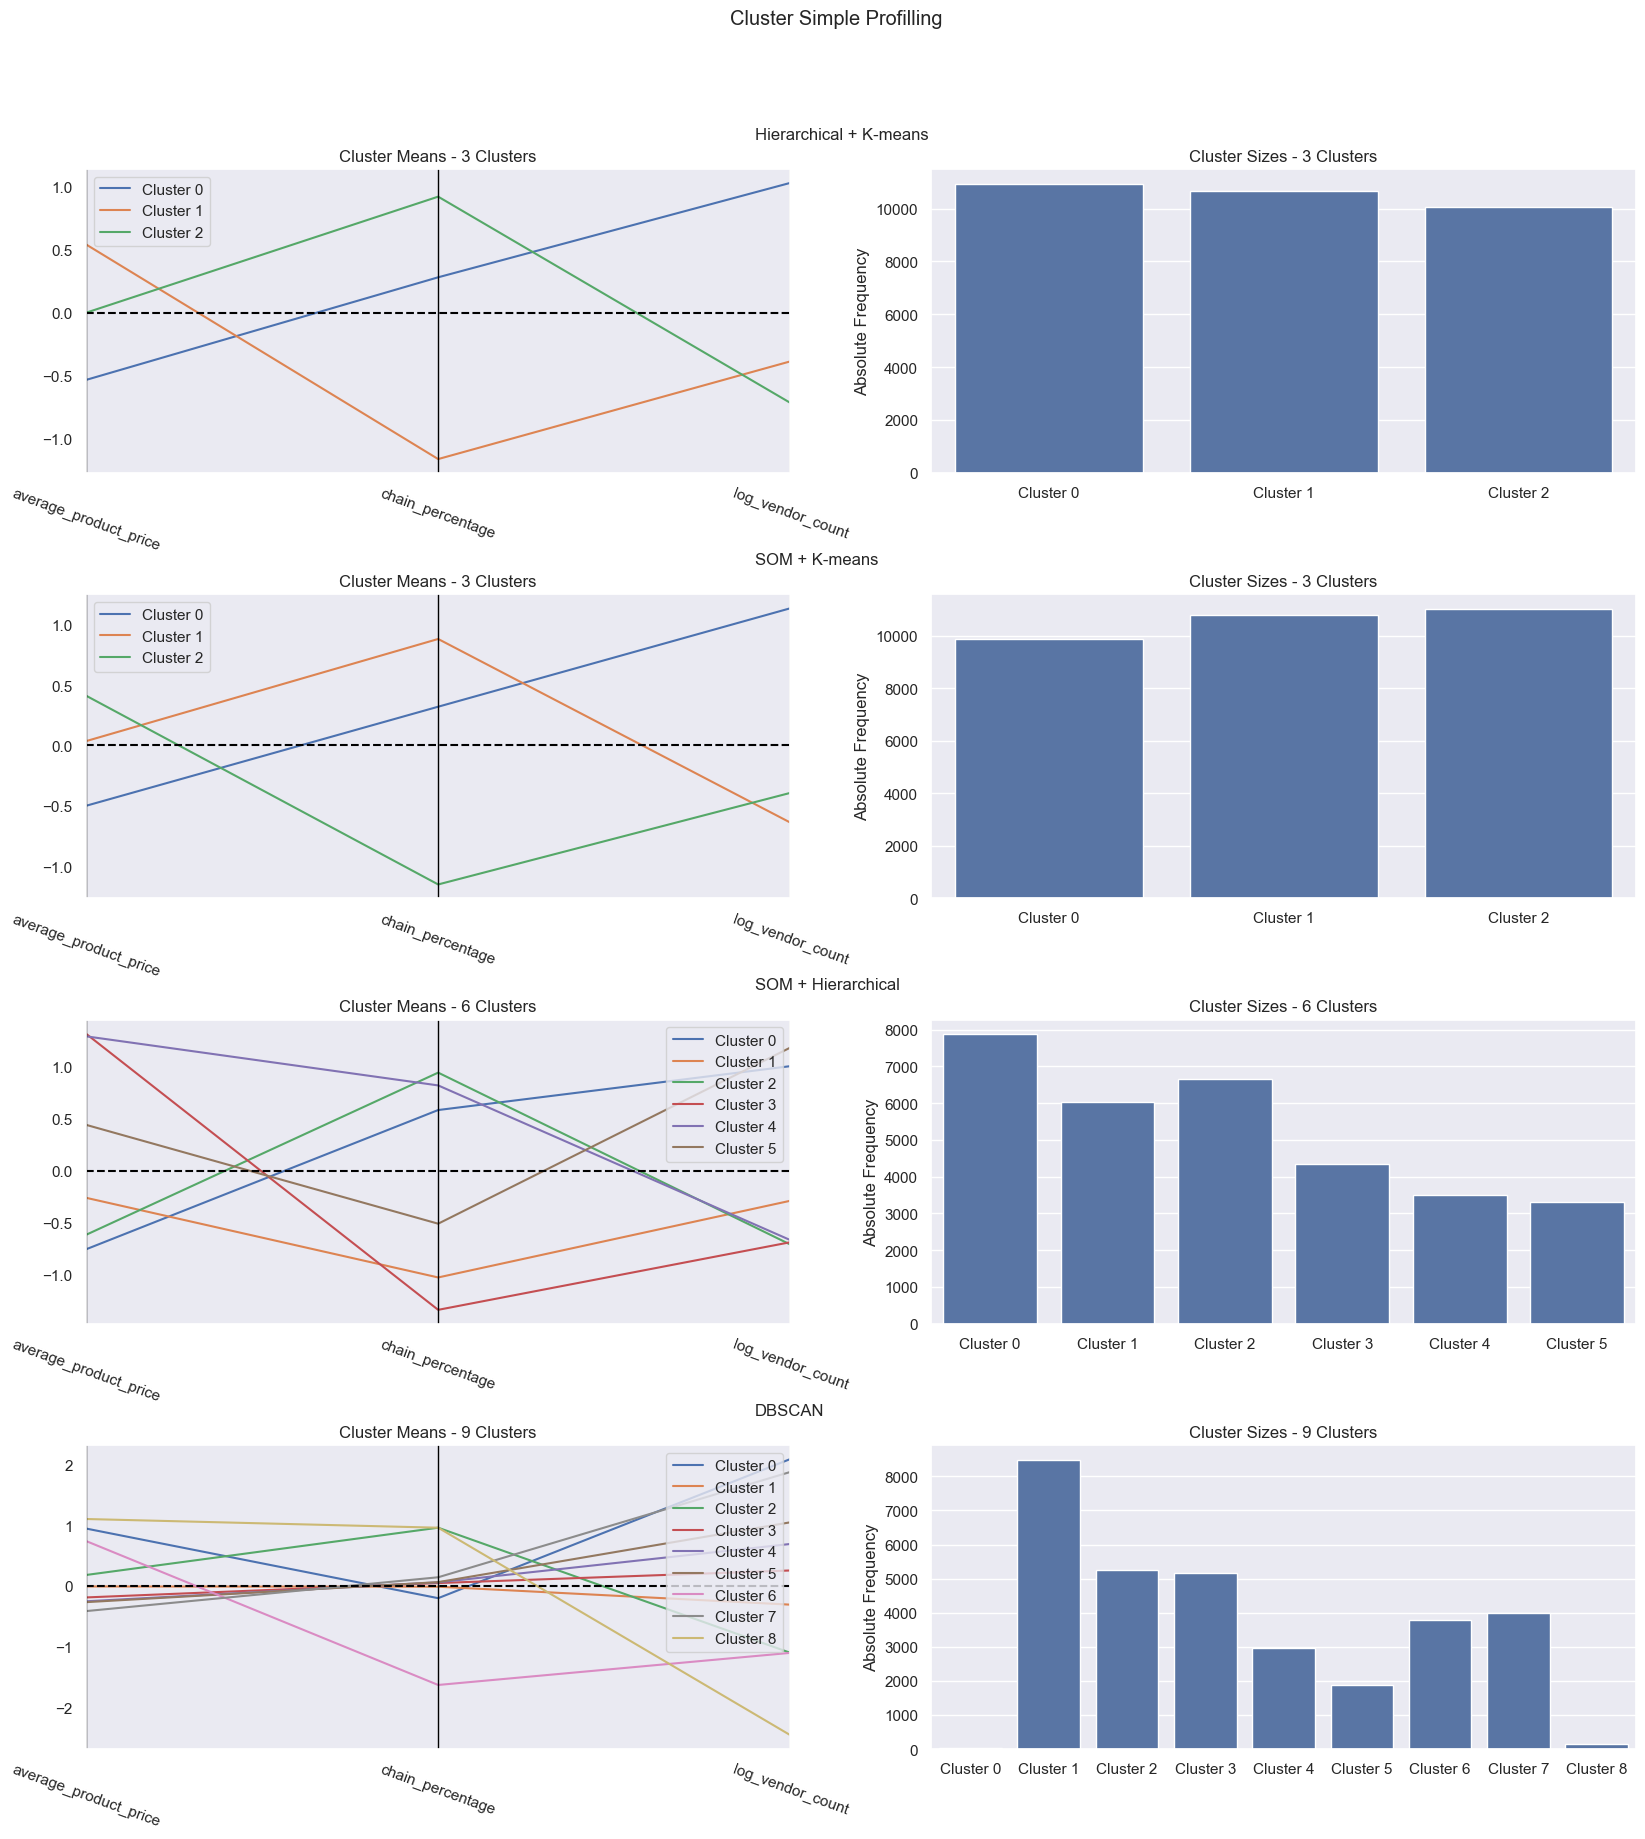

In [146]:
combined_df = pd.concat([df_eng1, df_somk_1, df_somh, df_dbscan], ignore_index=True)


label_columns = ['kmlust_labels', 'som_kmeans_labels', 'som_hierar_labels', 'dbscan_labels']

cluster_profiles(combined_df, label_columns, figsize=(20, 20),compar_titles = ["Hierarchical + K-means", "SOM + K-means", "SOM + Hierarchical", "DBSCAN"])


# 3. Final clusters for each segmentation


In [148]:
df_socio = df[demographics_preferences]
df_3 = df[purchase_behavior]

In [149]:
df_socio = df_socio.reset_index(drop=True)
df_3 = df_3.reset_index(drop=True)

df_analysis = pd.concat([df_socio, df_3], axis=1)
df_analysis

,customer_age,Recency,log_order_rate_per_week,log_amount_spent_per_week,average_product_price,chain_percentage,log_vendor_count
0,-1.463397,2.699634,5.373406,3.823580,0.499788,0.957495,-0.306522
1,1.490629,2.699634,5.373406,2.894886,-0.734841,0.957495,-1.098006
2,-0.619389,2.656542,3.731085,3.574793,0.725499,-0.334027,-0.306522
3,-1.041393,2.656542,3.731085,4.288361,0.865613,-1.625548,-0.306522
4,1.771965,2.656542,3.731085,3.276592,1.204057,-1.625548,-0.306522
...,...,...,...,...,...,...,...
31706,0.365286,2.742726,0.941213,0.080469,2.580526,0.957495,-1.098006
31707,-0.619389,2.742726,-0.198511,0.080469,2.580526,-1.625548,-1.098006
31708,-0.478722,2.742726,-0.198511,0.080469,2.518857,0.957495,-1.098006
31709,0.927957,2.742726,0.109212,0.080469,1.097985,-1.625548,-1.098006


According to the several methods of clustering used to each segmentation, we decide that 3 clusters and 3 clusters are the best number for demographics_preferences and purchase_behavior respectively.

In [151]:
# Applying the right clustering (algorithm and number of clusters) for each perspective
hclust_socio = KMeans(
    n_clusters=3, 
    init='k-means++', 
    n_init=15, 
    random_state=1)
     
hc_labels_final = hclust_socio.fit_predict(df_socio)

# final cluster solution
kmclust4 = KMeans(
    n_clusters=3, 
    init='k-means++', 
    n_init=15, 
    random_state=1)

km_labels_final = kmclust4.fit_predict(df_3)

df['demographics_labels'] = hc_labels_final
df['purchase_behavior_labels'] = km_labels_final
#df_analysis['Value_labels'] = hc_labels_final
#df_analysis['Recency_labels'] = km_labels_final


In [152]:
# Count label frequencies (contigency table)

pd.crosstab(df['demographics_labels'],
            df['purchase_behavior_labels'])

purchase_behavior_labels,0,1,2
demographics_labels,,,
0,1199,1466,981
1,1135,2944,3970
2,8617,6274,5125


# 4. Merging using Hierarchical clustering

In [154]:
# Centroids of the concatenated cluster labels
df_centroids = df.groupby(['demographics_labels', 'purchase_behavior_labels']).mean()
df_centroids

customer_age   Recency  \
demographics_labels purchase_behavior_labels                           
0                   0                             0.003351 -0.298059   
                    1                             0.036645  0.304518   
                    2                            -0.021443  0.531784   
1                   0                            -0.047918  0.920726   
                    1                            -0.024704  1.344837   
                    2                            -0.045521  1.409445   
2                   0                             0.009168 -0.655997   
                    1                             0.016710 -0.518149   
                    2                             0.017033 -0.450120   

                                              average_product_price  \
demographics_labels purchase_behavior_labels                          
0                   0                                     -0.295530   
                    1                                      0.580840   
                    2                                     -0.006822   
1                   0                                     -0.771126   
                    1                                      0.687367   
                    2                                      0.065545   
2                   0                                     -0.532967   
                    1                                      0.467888   
                    2                                     -0.047224   

                                              chain_percentage  \
demographics_labels purchase_behavior_labels                     
0                   0                                 0.081837   
                    1                                -0.959018   
                    2                                 0.919849   
1                   0                                 0.419763   
                    1                                -1.321043   
                    2                                 0.941896   
2                   0                                 0.292284   
                    1                                -1.129680   
                    2                                 0.906891   

                                              log_vendor_count  \
demographics_labels purchase_behavior_labels                     
0                   0                                 1.545749   
                    1                                -0.195516   
                    2                                -0.430258   
1                   0                                 0.517394   
                    1                                -0.725591   
                    2                                -0.890672   
2                   0                                 1.027629   
                    1                                -0.267762   
                    2                                -0.631203   

                                              log_order_rate_per_week  \
demographics_labels purchase_behavior_labels                            
0                   0                                        1.712828   
                    1                                        1.974781   
                    2                                        2.481262   
1                   0                                        0.132673   
                    1                                       -0.136791   
                    2                                       -0.087618   
2                   0                                       -0.187180   
                    1                                       -0.472280   
                    2                                       -0.430603   

                                              log_amount_spent_per_week  
demographics_labels purchase_behavior_labels                             
0                   0                                          1.

In [155]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
linkage = 'ward'
hclust = AgglomerativeClustering(
    linkage=linkage, 
    metric='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)
hclust_labels = hclust.fit_predict(df_centroids)

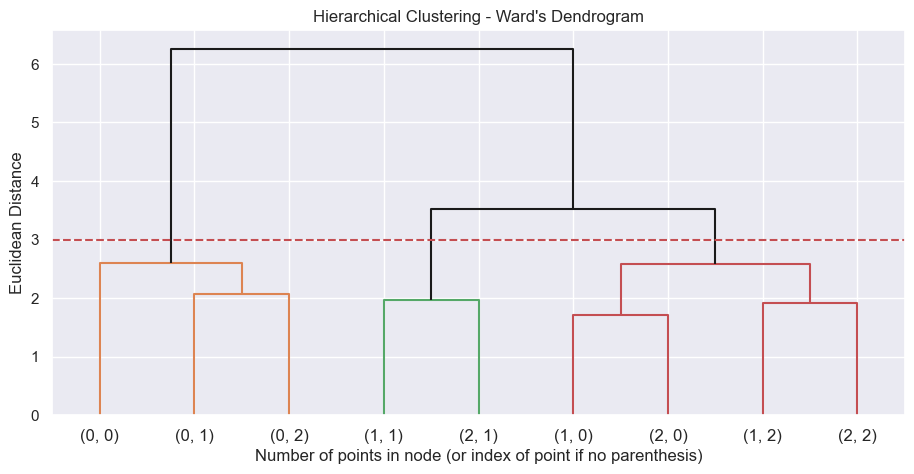

In [156]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 3
dendrogram(linkage_matrix, 
           truncate_mode='level', 
           labels=df_centroids.index, p=5, 
           color_threshold=y_threshold, 
           above_threshold_color='k')

plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram')
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance')
plt.show()

At this level, the dendrogram splits into 4 distinct clusters before merging into larger clusters.
Beyond this point, the vertical distances between merges (heights of the black lines) increase significantly, indicating that merging clusters further would group dissimilar data points together.
Cutting the dendrogram at this level yields well-separated clusters based on the structure of the tree.

In [158]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    metric='euclidean', 
    n_clusters=3
)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

df_centroids  # centroid's cluster labels

customer_age   Recency  \
demographics_labels purchase_behavior_labels                           
0                   0                             0.003351 -0.298059   
                    1                             0.036645  0.304518   
                    2                            -0.021443  0.531784   
1                   0                            -0.047918  0.920726   
                    1                            -0.024704  1.344837   
                    2                            -0.045521  1.409445   
2                   0                             0.009168 -0.655997   
                    1                             0.016710 -0.518149   
                    2                             0.017033 -0.450120   

                                              average_product_price  \
demographics_labels purchase_behavior_labels                          
0                   0                                     -0.295530   
                    1                                      0.580840   
                    2                                     -0.006822   
1                   0                                     -0.771126   
                    1                                      0.687367   
                    2                                      0.065545   
2                   0                                     -0.532967   
                    1                                      0.467888   
                    2                                     -0.047224   

                                              chain_percentage  \
demographics_labels purchase_behavior_labels                     
0                   0                                 0.081837   
                    1                                -0.959018   
                    2                                 0.919849   
1                   0                                 0.419763   
                    1                                -1.321043   
                    2                                 0.941896   
2                   0                                 0.292284   
                    1                                -1.129680   
                    2                                 0.906891   

                                              log_vendor_count  \
demographics_labels purchase_behavior_labels                     
0                   0                                 1.545749   
                    1                                -0.195516   
                    2                                -0.430258   
1                   0                                 0.517394   
                    1                                -0.725591   
                    2                                -0.890672   
2                   0                                 1.027629   
                    1                                -0.267762   
                    2                                -0.631203   

                                              log_order_rate_per_week  \
demographics_labels purchase_behavior_labels                            
0                   0                                        1.712828   
                    1                                        1.974781   
                    2                                        2.481262   
1                   0                                        0.132673   
                    1                                       -0.136791   
                    2                                       -0.087618   
2                   0                                       -0.187180   
                    1                                       -0.472280   
                    2                                       -0.430603   

                                              log_amount_spent_per_week  \
demographics_labels purchase_behavior_labels                              
0                   0                                          

In [159]:
# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_centroids['hclust_labels'].to_dict()
cluster_mapper


{(0, 0): 0,
 (0, 1): 0,
 (0, 2): 0,
 (1, 0): 1,
 (1, 1): 2,
 (1, 2): 1,
 (2, 0): 1,
 (2, 1): 2,
 (2, 2): 1}

In [160]:
df_ = df.copy()
# df_2 = df_analysis.copy()

# Mapping the hierarchical clusters on the centroids to the observations
df_['merged_labels'] = df_.apply(
    lambda row: cluster_mapper[
        (row['demographics_labels'], row['purchase_behavior_labels'])
    ], axis=1
)

'''df_2['merged_labels'] = df_2.apply(
    lambda row: cluster_mapper[
        (row['Value_labels'], row['Recency_labels'])
    ], axis=1
)
df_ca_analysis['merged_labels'] = df_ca_analysis.apply(
        lambda row: cluster_mapper[
        (row['Value_labels'], row['Recency_labels'])
    ], axis=1
)
# Merged cluster centroids
df_ca_analysis.groupby('merged_labels').mean()'''

"df_2['merged_labels'] = df_2.apply(\n    lambda row: cluster_mapper[\n        (row['Value_labels'], row['Recency_labels'])\n    ], axis=1\n)\ndf_ca_analysis['merged_labels'] = df_ca_analysis.apply(\n        lambda row: cluster_mapper[\n        (row['Value_labels'], row['Recency_labels'])\n    ], axis=1\n)\n# Merged cluster centroids\ndf_ca_analysis.groupby('merged_labels').mean()"

In [161]:
df_.groupby('merged_labels').mean(numeric_only=True)[metric_features]

,customer_age,Recency,average_product_price,chain_percentage,log_vendor_count,log_order_rate_per_week,log_amount_spent_per_week
merged_labels,,,,,,,
0,0.010067,0.167507,0.134525,-0.111198,0.313945,2.024912,1.892149
1,-0.003651,-0.069988,-0.289150,0.603926,0.141743,-0.213139,-0.341223
2,0.003483,0.076843,0.537984,-1.190796,-0.413982,-0.365133,-0.050742


In [162]:
#Merge cluster contigency table
# Getting size of each final cluster
df_counts = df_.groupby('merged_labels')\
    .size()\
    .to_frame()

df_counts

,0
merged_labels,
0,3646
1,18847
2,9218


In [163]:
# Getting the product and behavior labels
df_counts = df_counts\
    .rename({v:k for k, v in cluster_mapper.items()})\
    .reset_index()
df_counts

,merged_labels,0
0,"(0, 2)",3646
1,"(2, 2)",18847
2,"(2, 1)",9218


In [164]:

df_counts['demographics_labels'] = df_counts['merged_labels'].apply(lambda x: x[0])
df_counts['purchase_behavior_labels'] = df_counts['merged_labels'].apply(lambda x: x[1])


df_counts.pivot(values=0, index='demographics_labels', columns='purchase_behavior_labels')

purchase_behavior_labels,1,2
demographics_labels,,
0,NaN,3646.0
2,9218.0,18847.0


In [165]:
# Setting df to have the final product, behavior and merged clusters
df = df_.copy()

In [166]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31711 entries, 0 to 31710
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer_age               31711 non-null  float64
 1   Recency                    31711 non-null  float64
 2   average_product_price      31711 non-null  float64
 3   chain_percentage           31711 non-null  float64
 4   log_vendor_count           31711 non-null  float64
 5   log_order_rate_per_week    31711 non-null  float64
 6   log_amount_spent_per_week  31711 non-null  float64
 7   demographics_labels        31711 non-null  int32  
 8   purchase_behavior_labels   31711 non-null  int32  
 9   merged_labels              31711 non-null  int64  
dtypes: float64(7), int32(2), int64(1)
memory usage: 2.2 MB


# 5.Cluster Analysis 


## Cluster profiles graphs

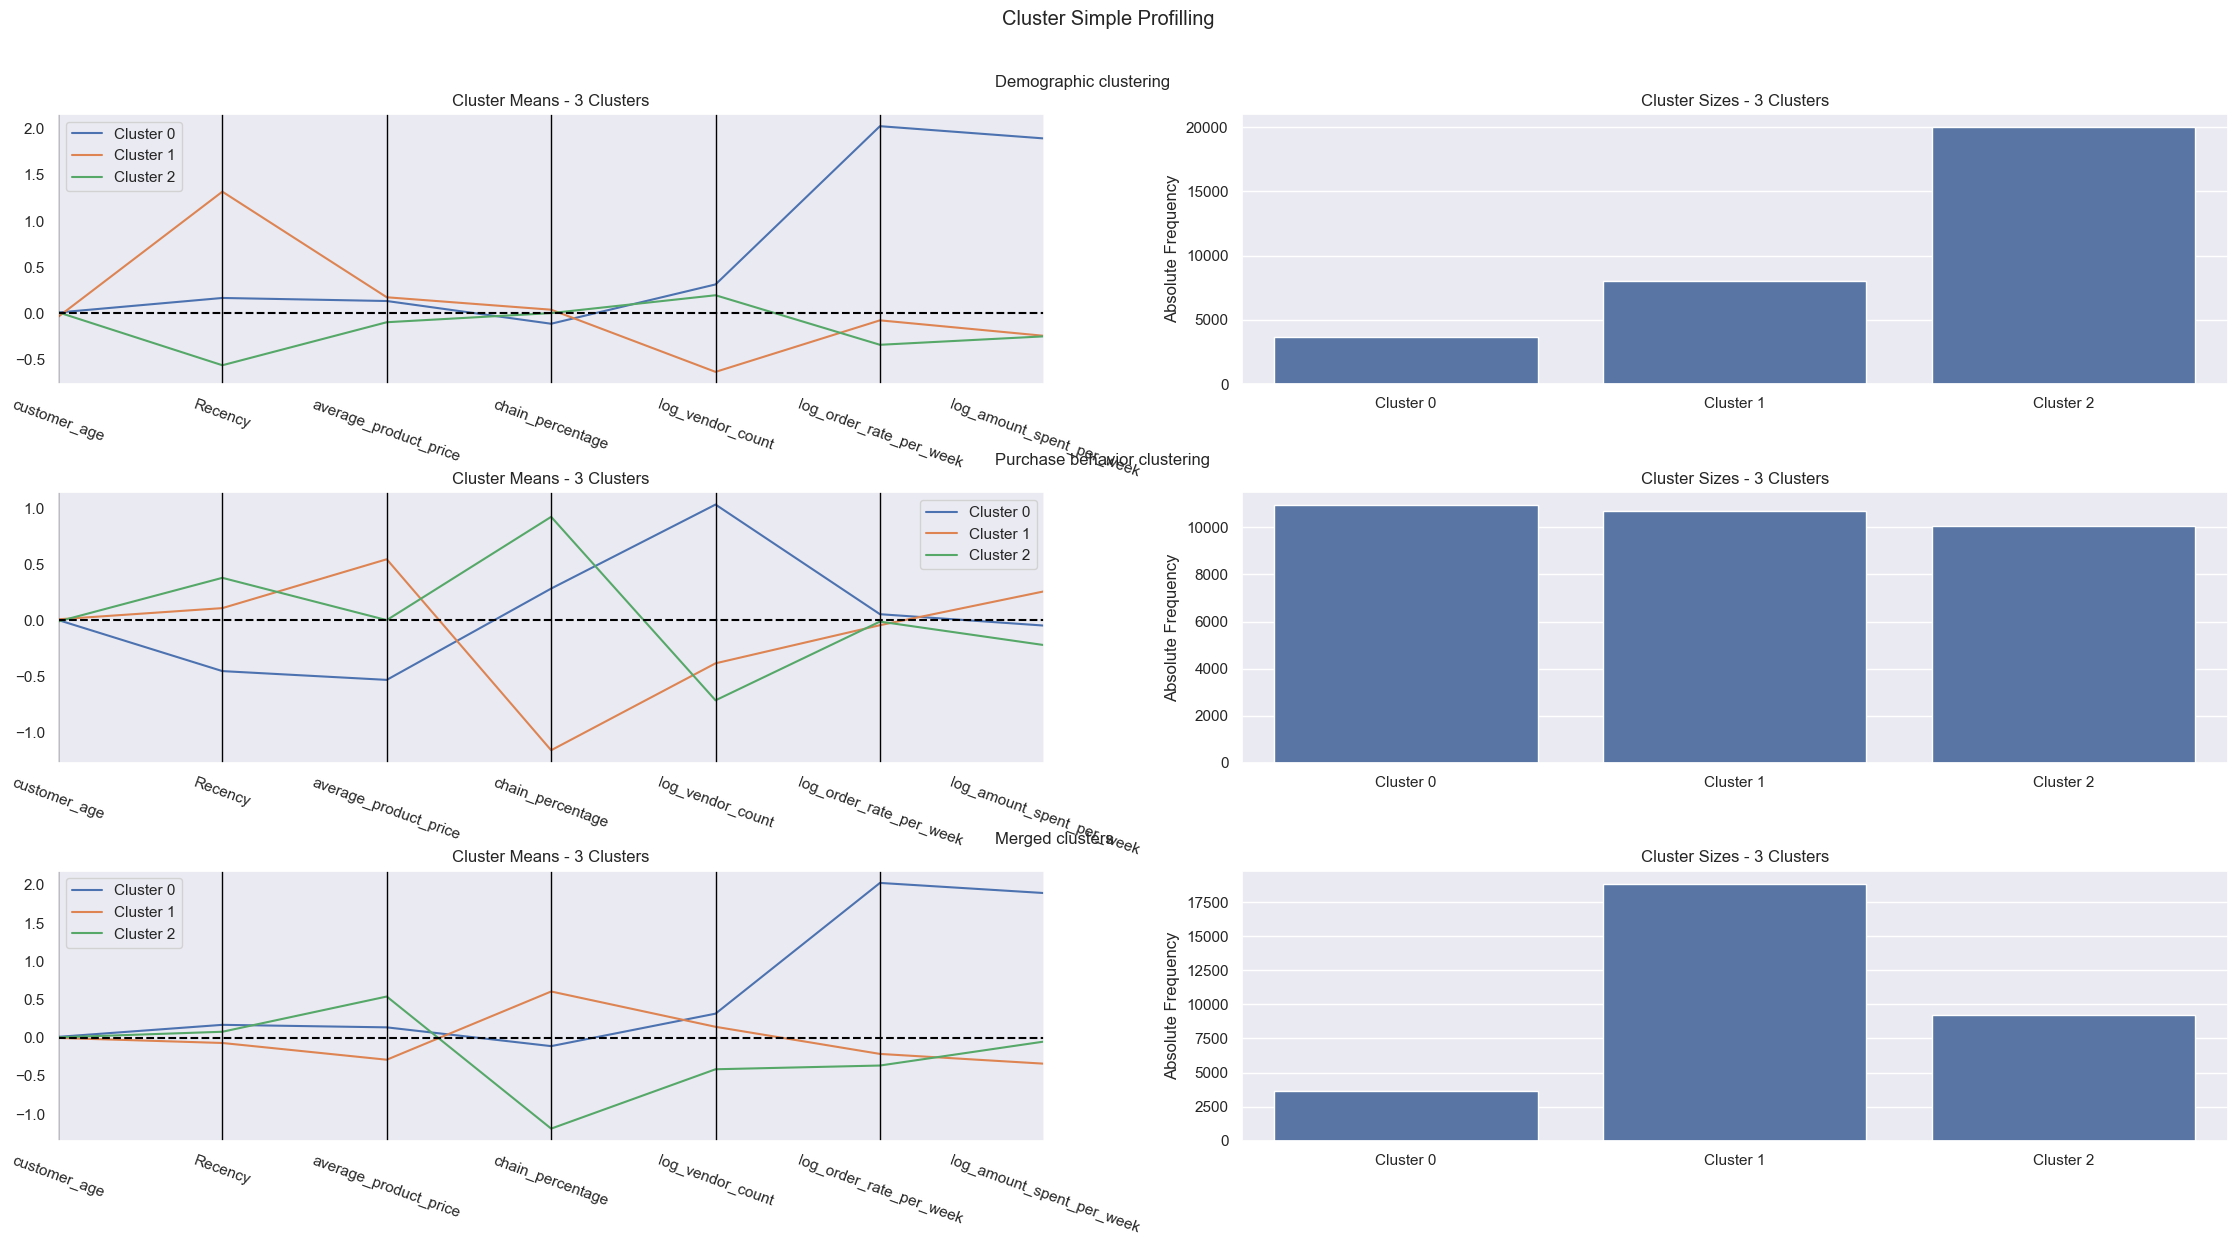

In [169]:
# Profilling each cluster (product, behavior, merged)
cluster_profiles(
    df = df, 
    label_columns = ['demographics_labels', 'purchase_behavior_labels', 'merged_labels'], 
    figsize = (28, 13), 
    compar_titles = ["Demographic clustering", "Purchase behavior clustering", "Merged clusters"]
)

## Profiling with the numerical features

In [171]:
df_.groupby('merged_labels').mean(numeric_only=True)[metric_features]

,customer_age,Recency,average_product_price,chain_percentage,log_vendor_count,log_order_rate_per_week,log_amount_spent_per_week
merged_labels,,,,,,,
0,0.010067,0.167507,0.134525,-0.111198,0.313945,2.024912,1.892149
1,-0.003651,-0.069988,-0.289150,0.603926,0.141743,-0.213139,-0.341223
2,0.003483,0.076843,0.537984,-1.190796,-0.413982,-0.365133,-0.050742


### Merged Label: 0.0

#### Key Observations:
- Customers in this group show **higher-than-average `log_order_rate_per_week` (2.02)** and **`log_amount_spent_per_week` (1.89)**. This suggests that they are **high-frequency purchasers with significant spending habits**.
- They prefer **higher average product prices (0.13)** and show a **positive `log_vendor_count` (0.31)**, indicating a willingness to purchase from a wide variety of vendors.
- Negative `chain_percentage` (-0.11) suggests **less likelihood to shop at chain stores**.

#### Actionable Insights:
- **Target this group with premium products** and exclusive, high-value promotions to align with their spending habits and preferences.
- **Focus on independent vendors** and unique offerings rather than chain stores.
- Highlight products that **encourage high-frequency purchasing and repeat buying**.

---

### Merged Label: 1.0

#### Key Observations:
- Customers in this group have a **significant positive `chain_percentage` (0.60)**, indicating a **strong preference for chain stores**.
- **Lower-than-average spending** is reflected in **negative `log_order_rate_per_week` (-0.21)** and **`log_amount_spent_per_week` (-0.34)**.
- They prefer **lower average product prices (-0.29)** and show **slightly positive recency (-0.06)**, indicating **less frequent but recent purchasing**.

#### Actionable Insights:
- **Target this group with promotions at chain stores**, focusing on **discounts and bundled offers** to encourage higher spending.
- Highlight **value-for-money products** with lower price points.
- Leverage campaigns promoting **loyalty programs** or discounts for recent purchases to increase their engagement.

---

### Merged Label: 2.0

#### Key Observations:
- Customers in this group display **low `chain_percentage` (-1.19)**, suggesting a **strong preference for independent vendors or niche products**.
- They are **moderate spenders**, as reflected in **`log_order_rate_per_week` (0.36)** and **`log_amount_spent_per_week` (-0.05)**.
- Their preference for **higher-priced products (0.53)** suggests a **mix of selective yet quality-conscious purchasing**.

#### Actionable Insights:
- **Focus on unique, high-quality products** from independent vendors to match their preferences.
- Highlight **personalized offers** to increase spending without relying on chain-store promotions.
- **Target campaigns for customers seeking premium quality** and niche offerings.

---

### Refined Marketing Insights
- **For Merged Label 0.0**: Premium, high-value campaigns for independent vendor offerings with a focus on loyalty.
- **For Merged Label 1.0**: Budget-conscious promotions targeted at chain stores with a focus on driving higher engagement and purchases.
- **For Merged Label 2.0**: Highlight high-quality, niche products and personalized campaigns to encourage spending from selective buyers.


## Profiling with unused / categorical features

### Importing categoricals

In [175]:
merged_labels_analysis= df_.copy()

In [176]:

data_cleaned_df = pd.read_csv("data_cleaned.csv")
merged_df = pd.merge(merged_labels_analysis, data_cleaned_df, how="outer")
columns_to_drop = metric_features + ['customer_id','demographics_labels', 'purchase_behavior_labels','total_amount_spent' ]
merged_df_dropped = merged_df.drop(columns=columns_to_drop, errors='ignore')
grouped_df = merged_df_dropped.groupby('merged_labels').mean().T
grouped_df

merged_labels,0.0,1.0,2.0
customer_region_2360,0.230088,0.367704,0.080952
customer_region_2440,0.026549,0.093385,0.020635
customer_region_2490,0.013274,0.021401,0.001587
customer_region_4140,0.030973,0.013619,0.042857
customer_region_4660,0.230088,0.272374,0.474603
customer_region_8370,0.008850,0.005837,0.061905
customer_region_8550,0.000000,0.000000,0.000000
customer_region_8670,0.433628,0.219844,0.306349
last_promo_DELIVERY,0.199115,0.132296,0.196825
last_promo_DISCOUNT,0.110619,0.122568,0.141270


Marketing Insights

For Merged Label 0.0:

 - Focus on "DELIVERY" promotions, as they resonate most with this group.
 - Emphasize Asian cuisine in marketing campaigns.
 - Target customer_region_8670, customer_region_2360, and customer_region_4660.
 - Consider campaigns balanced across City_2 and City_3.

For Merged Label 1.0:

 - Highlight "FREEBIE" promotions to attract this segment.
 - Showcase a diverse range of cuisines, particularly Japanese and Italian.
 - Target customers in City_3 and regions like customer_region_2360 and customer_region_4660.
   
For Merged Label 2.0:

 - Promote "DELIVERY" campaigns, with additional focus on Italian and Japanese cuisines.
 - Concentrate marketing efforts in City_2 and customer_region_4660.
 - Leverage digital payment options (DIGI) to encourage transactions.

# 6. Cluster visualization using t-SNE

In [179]:
# This is step can be quite time consuming
two_dim = TSNE(random_state=42).fit_transform(df)

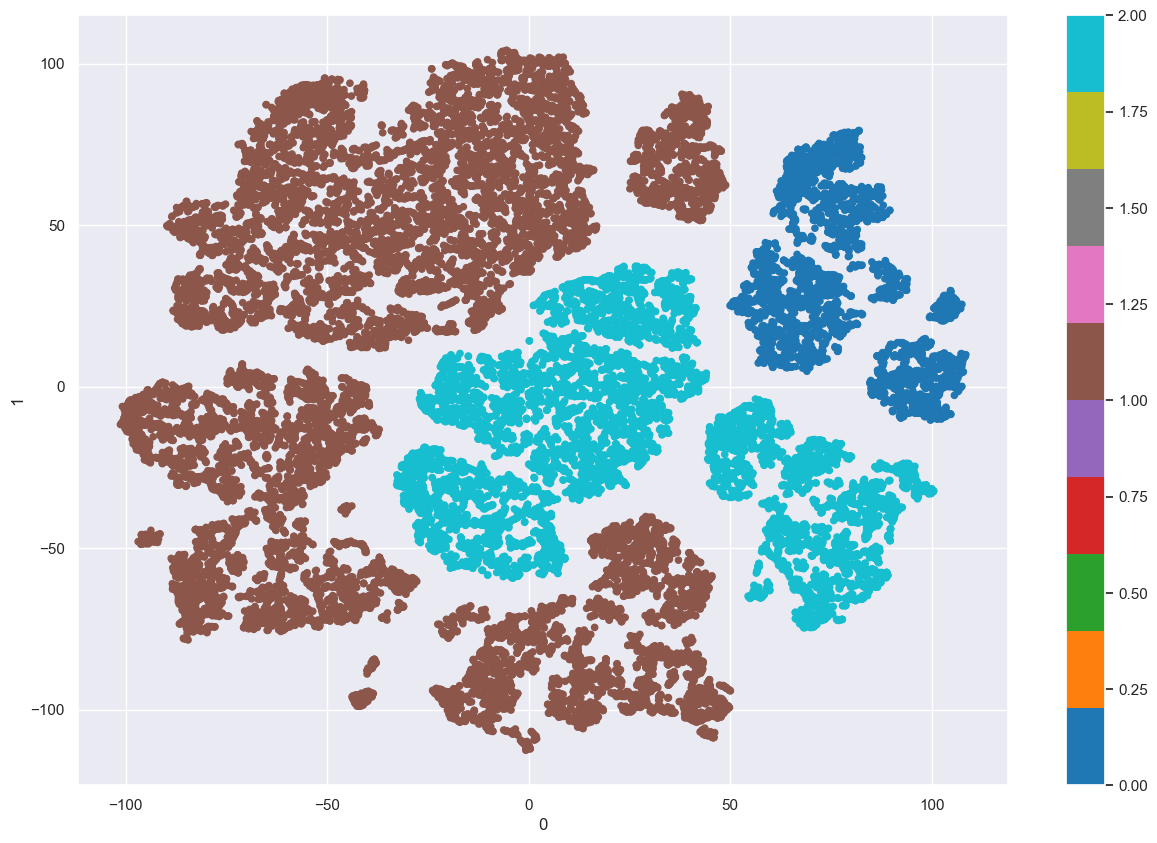

In [180]:
# t-SNE visualization
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df['merged_labels'], colormap='tab10', figsize=(15,10))
plt.show()

# 7. Feature Importance

In [182]:
def get_ss_variables(df):
    """Get the SS for each variable
    """
    ss_vars = df.var() * (df.count() - 1)
    return ss_vars

def r2_variables(df, labels):
    """Get the R² for each variable
    """
    sst_vars = get_ss_variables(df)
    ssw_vars = np.sum(df.groupby(labels).apply(get_ss_variables))
    return 1 - ssw_vars/sst_vars

In [183]:
# We are essentially decomposing the R² into the R² for each variable
r2_variables(df[metric_features + ['merged_labels']], 'merged_labels').drop('merged_labels')

customer_age                 0.000023
Recency                      0.007854
average_product_price        0.135905
chain_percentage             0.630386
log_vendor_count             0.073091
log_order_rate_per_week      0.537187
log_amount_spent_per_week    0.481589
dtype: float64

### Using a Decision Tree
We get the normalized total reduction of the criterion (gini or entropy) brought by that feature (also known as Gini importance).

In [185]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31711 entries, 0 to 31710
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer_age               31711 non-null  float64
 1   Recency                    31711 non-null  float64
 2   average_product_price      31711 non-null  float64
 3   chain_percentage           31711 non-null  float64
 4   log_vendor_count           31711 non-null  float64
 5   log_order_rate_per_week    31711 non-null  float64
 6   log_amount_spent_per_week  31711 non-null  float64
 7   demographics_labels        31711 non-null  int32  
 8   purchase_behavior_labels   31711 non-null  int32  
 9   merged_labels              31711 non-null  int64  
dtypes: float64(7), int32(2), int64(1)
memory usage: 2.2 MB


In [186]:
# Preparing the data
X = df[metric_features]
y = df.merged_labels

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fitting the decision tree
dt = DecisionTreeClassifier(random_state=42, max_depth=3)
dt.fit(X_train, y_train)
print("It is estimated that in average, we are able to predict {0:.2f}% of the customers correctly".format(dt.score(X_test, y_test)*100))

It is estimated that in average, we are able to predict 92.15% of the customers correctly


In [187]:
# Assessing feature importance
pd.Series(dt.feature_importances_, index=X_train.columns).sort_values(ascending=False)

chain_percentage             0.556378
log_order_rate_per_week      0.289400
log_vendor_count             0.081730
log_amount_spent_per_week    0.072492
customer_age                 0.000000
Recency                      0.000000
average_product_price        0.000000
dtype: float64

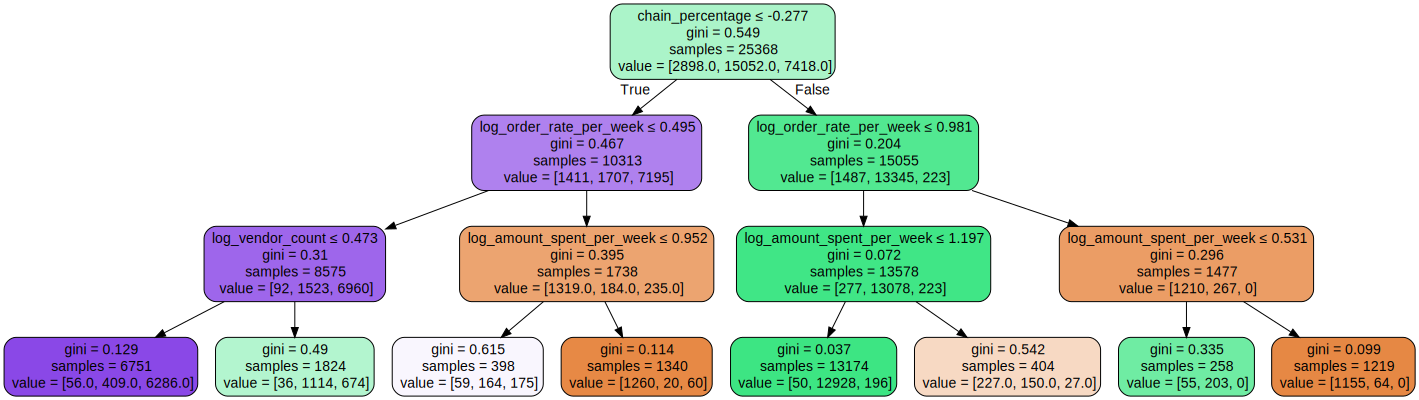

In [188]:
# Visualizing the decision tree
dot_data = export_graphviz(dt, out_file=None, 
                           feature_names=X.columns.to_list(),
                           filled=True,
                           rounded=True,
                           special_characters=True)
g = graphviz.Source(dot_data)

g